In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
import json
import requests
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import string
import mapclassify
from shapely.ops import unary_union
plt.style.use('ggplot')


# Opening GeoJSONs and exploring data

### Zoning data

In [2]:
zones_geodata = gpd.read_file('CME538_Daniel_Group_Zoning Area - 4326.geojson')
zones_geodata = zones_geodata.set_index(zones_geodata.columns[0])
zones_geodata.head()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


GEN_ZONE ZN_ZONE ZN_HOLDING  HOLDING_ID  FRONTAGE  ZN_AREA  UNITS  \
_id                                                                      
1           2      UT          N           0      -1.0       -1     -1   
2           1      ON          N           0      -1.0       -1     -1   
3           0      RD          N           0      14.0      510      0   
4           1       O          N           0      -1.0       -1     -1   
5           0      RD          N           0       0.0        0      0   

     DENSITY  COVERAGE  FSI_TOTAL  ...  ZN_EXCPTN  EXCPTN_NO  STAND_SET  \
_id                                ...                                    
1       -1.0       0.0       -1.0  ...          N          0         -1   
2       -1.0       0.0       -1.0  ...          N          0         -1   
3        0.0       0.0       -1.0  ...          Y       1058         -1   
4       -1.0       0.0       -1.0  ...          N          0         -1   
5        0.0       0.0       -1.0  ...          Y       1040         -1   

     ZN_STATUS                 ZN_STRING  AREA_UNITS  ZBL_CHAPT  ZBL_SECTN  \
_id                                                                          
1            2                        UT        -1.0        100     100.10   
2            0                        ON        -1.0         90      90.20   
3            2  RD (f14.0; a510) (x1058)         0.0         10      10.20   
4            3                         O        -1.0         90      90.10   
5            2                RD (x1040)         0.0         10      10.20   

         ZBL_EXCPTN                                           geometry  
_id                                                                     
1                    MULTIPOLYGON (((-79.20970 43.81729, -79.20961 ...  
2                    MULTIPOLYGON (((-79.50273 43.70976, -79.50195 ...  
3    900.3.10(1058)  MULTIPOLYGON (((-79.27433 43.80068, -79.27425 ...  
4                    MULTIPOLYGON (((-79.57040 43.72175, -79.57042 ...  
5    900.3.10(1040)  MULTIPOLYGON (((-79.26202 43.81195, -79.26214 ...  

[5 rows x 24 columns]

From the description of data: 

**ZN_ZONE**

The land use category of the lands within the zone boundary. Each 'zone category' has its own Chapter in the text of By-law 569-2013. Zoned destination of the zone limited by GEN_ZONE. 
- 0 = Residential 
- 1 = Open Space 
- 2 = Utility and Transportation 
- 4 = Employment Industrial 
- 5 = Institutional 
- 6 = Commercial Residential Employment 
- 101 = Residential Apartment 
- 201 = Commercial 
- 202 = Commercial Residential

In [3]:
zones_geodata.GEN_ZONE.unique()

array([  2,   1,   0,   4, 201, 202, 101,   6,   5])

In [4]:
# Only keep zoning type, and geometry, rest is not relevant
zones_geodata_cleaned = zones_geodata[['GEN_ZONE', 'geometry']]

# Rename 'GEN_ZONE' to 'Zone_type'
zones_geodata_cleaned.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)

# Define the mapping for Zone Type values
zone_mapping = {0: 'Residential', 1: 'Open Space', 2: 'Utility and Transportation', 
                4: 'Employment Industrial', 5: 'Institutional',
                6: 'Commercial Residential Employment', 101: 'Residential Apartment', 
                201: 'Commercial', 202: 'Commercial Residential'}

# Replace the values in 'Zone_type' column with the mapped names
zones_geodata_cleaned['Zone_type'] = zones_geodata_cleaned['Zone_type'].replace(zone_mapping)

# Display the first few rows to ensure it worked
zones_geodata_cleaned.head()


/tmp/ipykernel_87/1307462323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zones_geodata_cleaned.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Zone_type  \
_id                               
1    Utility and Transportation   
2                    Open Space   
3                   Residential   
4                    Open Space   
5                   Residential   

                                              geometry  
_id                                                     
1    MULTIPOLYGON (((-79.20970 43.81729, -79.20961 ...  
2    MULTIPOLYGON (((-79.50273 43.70976, -79.50195 ...  
3    MULTIPOLYGON (((-79.27433 43.80068, -79.27425 ...  
4    MULTIPOLYGON (((-79.57040 43.72175, -79.57042 ...  
5    MULTIPOLYGON (((-79.26202 43.81195, -79.26214 ...

In [5]:
zones_geodata_cleaned.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

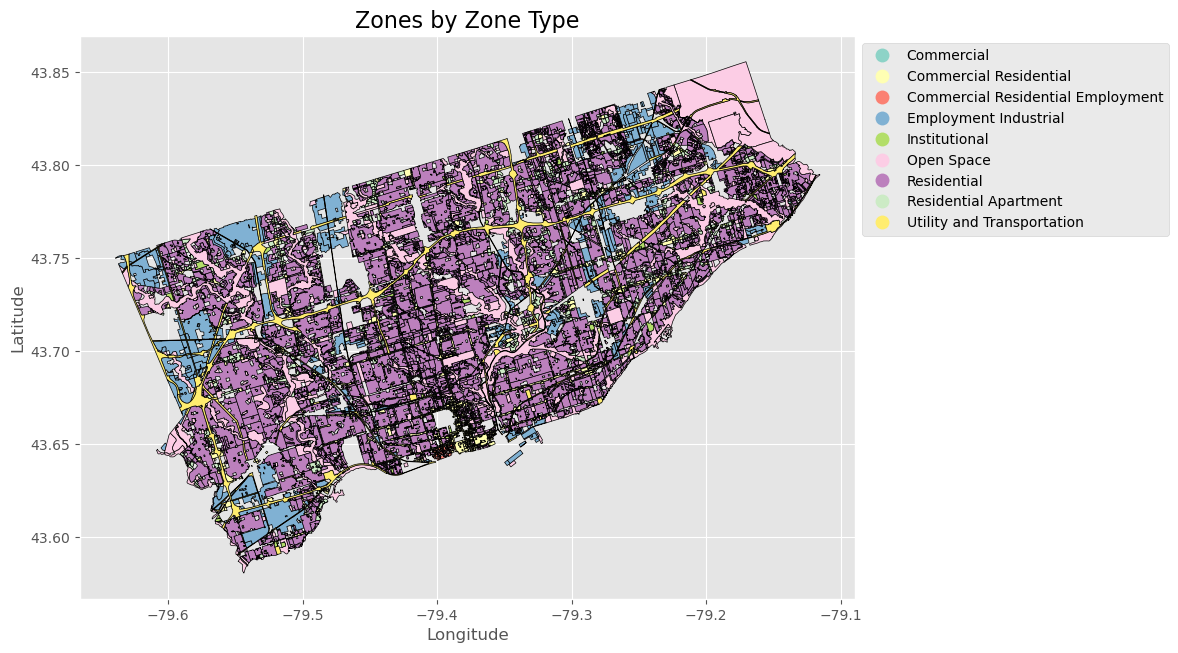

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with categorical coloring based on 'Zone_type'
zones_geodata_cleaned.plot(column='Zone_type', ax=ax, legend=True, 
                           legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                           cmap='Set3', edgecolor='black')

# Add labels
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Zones by Zone Type', fontsize=16)

# Display the plot
plt.show()

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


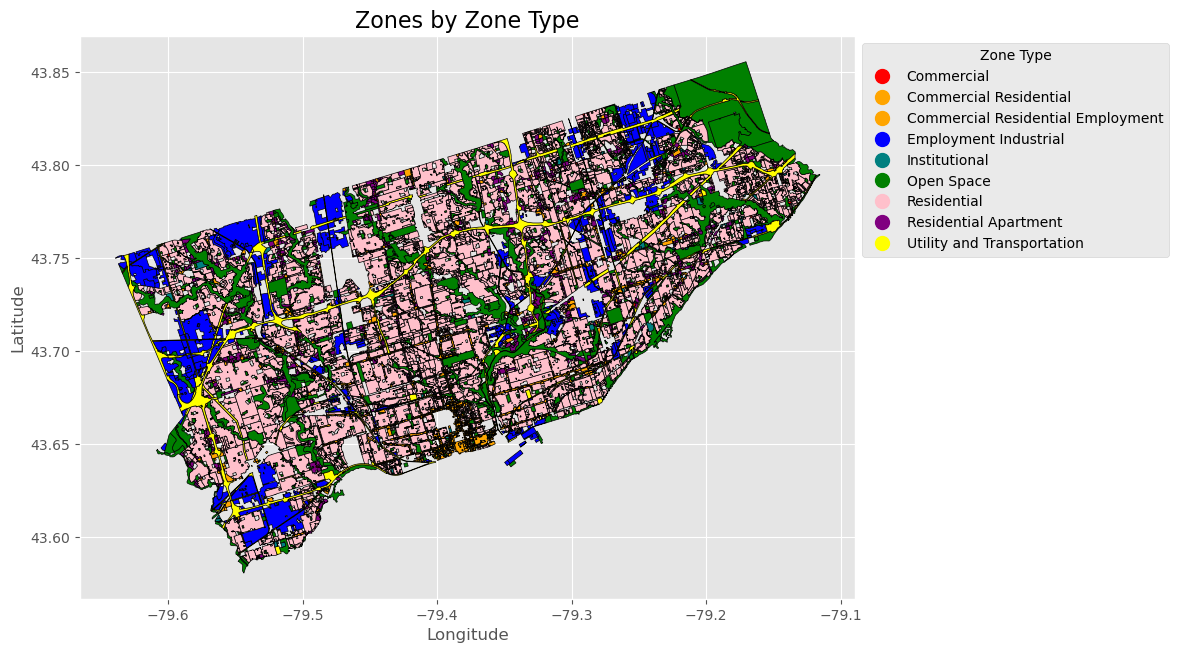

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a dictionary for the specific colors for each Zone_type
custom_colors = {
    'Commercial': 'red',
    'Commercial Residential': 'orange',
    'Commercial Residential Employment': 'orange',
    'Employment Industrial': 'blue',
    'Institutional': 'teal',
    'Open Space': 'green',
    'Residential': 'pink',
    'Residential Apartment': 'purple',
    'Utility and Transportation': 'yellow'
}

# Map Zone_type to colors
zones_geodata_cleaned['color'] = zones_geodata_cleaned['Zone_type'].map(custom_colors)

# Create a custom legend manually
legend_labels = list(custom_colors.keys())
legend_colors = [custom_colors[label] for label in legend_labels]

# Plot with the custom colors
fig, ax = plt.subplots(figsize=(10, 8))
zones_geodata_cleaned.plot(color=zones_geodata_cleaned['color'], ax=ax, edgecolor='black')

# Add custom legend
handles = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10, linestyle='') 
           for label, color in zip(legend_labels, legend_colors)]
ax.legend(handles=handles, title='Zone Type', bbox_to_anchor=(1, 1), loc='upper left')

# Add labels and title
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Zones by Zone Type', fontsize=16)

# Display the plot
plt.show()


### Greenspace data

In [8]:
greenspace = gpd.read_file('Green Spaces - 4326.geojson')
greenspace = greenspace.set_index(greenspace.columns[0])
greenspace.head()

AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID  AREA_CLASS_ID      AREA_CLASS  \
_id                                                                         
1          1             1               0          890.0  OTHER_CEMETERY   
2          2             2               0          890.0  OTHER_CEMETERY   
3          3             3               0          890.0  OTHER_CEMETERY   
4          4             4               0          890.0  OTHER_CEMETERY   
5          5             5               0          890.0  OTHER_CEMETERY   

    AREA_SHORT_CODE AREA_LONG_CODE                            AREA_NAME  \
_id                                                                       
1              None           4009     ARMADALE FREE METHODIST CEMETERY   
2              None           4010                    HILLSIDE CEMETERY   
3              None           4011              HIGHLAND MEMORY GARDENS   
4              None           4005        CHRISTIE'S METHODIST CEMETERY   
5              None           4012  ST. PAUL'S ANGLICAN CHURCH CEMETERY   

                               AREA_DESC  OBJECTID  \
_id                                                  
1       ARMADALE FREE METHODIST CEMETERY       1.0   
2                      HILLSIDE CEMETERY       2.0   
3                HIGHLAND MEMORY GARDENS       3.0   
4          CHRISTIE'S METHODIST CEMETERY       4.0   
5    ST. PAUL'S ANGLICAN CHURCH CEMETERY       5.0   

                                              geometry  
_id                                                     
1    MULTIPOLYGON (((-79.25752 43.82953, -79.25739 ...  
2    MULTIPOLYGON (((-79.18962 43.82488, -79.18949 ...  
3    MULTIPOLYGON (((-79.34758 43.80810, -79.34758 ...  
4    MULTIPOLYGON (((-79.31835 43.79902, -79.31851 ...  
5    MULTIPOLYGON (((-79.31649 43.79640, -79.31650 ...

In [9]:
greenspace.columns.unique()

Index(['AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_CLASS_ID',
       'AREA_CLASS', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'AREA_NAME',
       'AREA_DESC', 'OBJECTID', 'geometry'],
      dtype='object')

In [10]:
greenspace_cleaned = greenspace[['AREA_CLASS', 'geometry']]
greenspace_cleaned.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)
greenspace_cleaned.head()


/tmp/ipykernel_87/3715004460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greenspace_cleaned.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)


Area_type                                           geometry
_id                                                                   
1    OTHER_CEMETERY  MULTIPOLYGON (((-79.25752 43.82953, -79.25739 ...
2    OTHER_CEMETERY  MULTIPOLYGON (((-79.18962 43.82488, -79.18949 ...
3    OTHER_CEMETERY  MULTIPOLYGON (((-79.34758 43.80810, -79.34758 ...
4    OTHER_CEMETERY  MULTIPOLYGON (((-79.31835 43.79902, -79.31851 ...
5    OTHER_CEMETERY  MULTIPOLYGON (((-79.31649 43.79640, -79.31650 ...

In [11]:
greenspace_cleaned.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

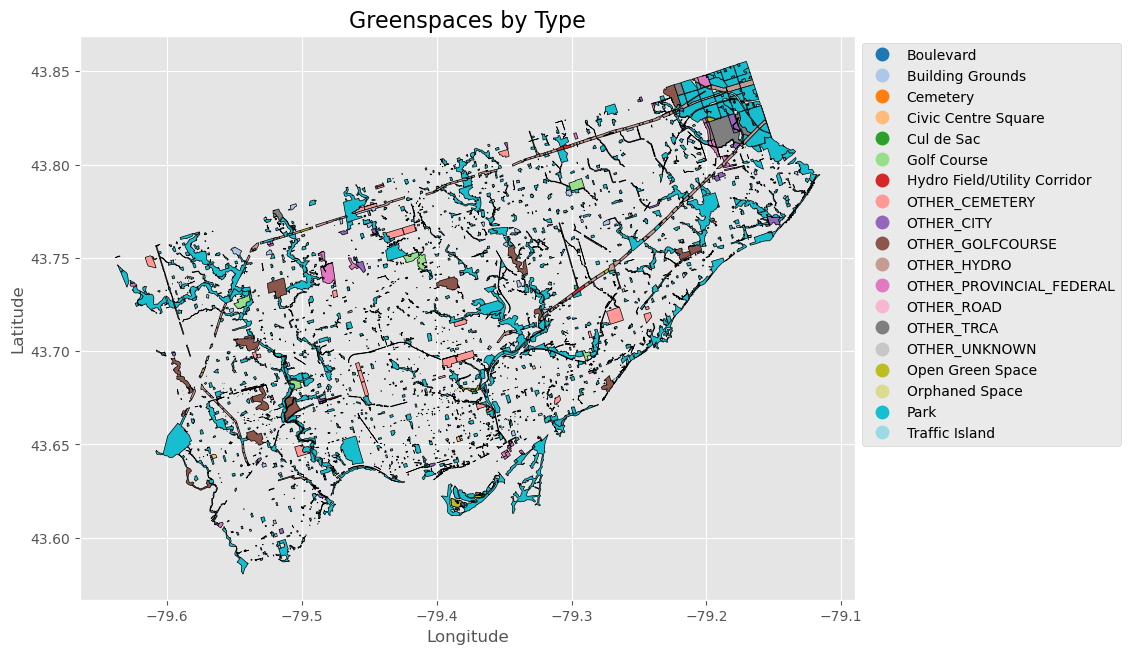

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with categorical coloring based on 'Zone_type'
greenspace_cleaned.plot(column='Area_type', ax=ax, legend=True, 
                           legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                           cmap='tab20', edgecolor='black')

# Add labels
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Greenspaces by Type', fontsize=16)

# Display the plot
plt.show()

### Flood plains data

In [13]:
flood_plains = gpd.read_file('Floodline GeoJson Format.geojson')
flood_plains = flood_plains.set_index(flood_plains.columns[0])
flood_plains.head()


FloodPlain     Watershed    Shape__Are   Shape__Len  \
OBJECTID                                                        
3394      Engineered     Don River      0.940918     3.803569   
3395      Engineered     Don River    869.856689   149.201240   
3396      Engineered     Don River  23187.910400  1321.226703   
3397      Engineered     Don River  10895.613037   522.001575   
3406      Engineered  Humber River      0.544922     5.605709   

                                                   geometry  
OBJECTID                                                     
3394      MULTIPOLYGON (((-79.36482 43.67112, -79.36482 ...  
3395      MULTIPOLYGON (((-79.38004 43.67332, -79.38004 ...  
3396      MULTIPOLYGON (((-79.37672 43.67350, -79.37671 ...  
3397      MULTIPOLYGON (((-79.37840 43.67362, -79.37840 ...  
3406      MULTIPOLYGON (((-79.50360 43.71073, -79.50360 ...

In [14]:
flood_plains.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

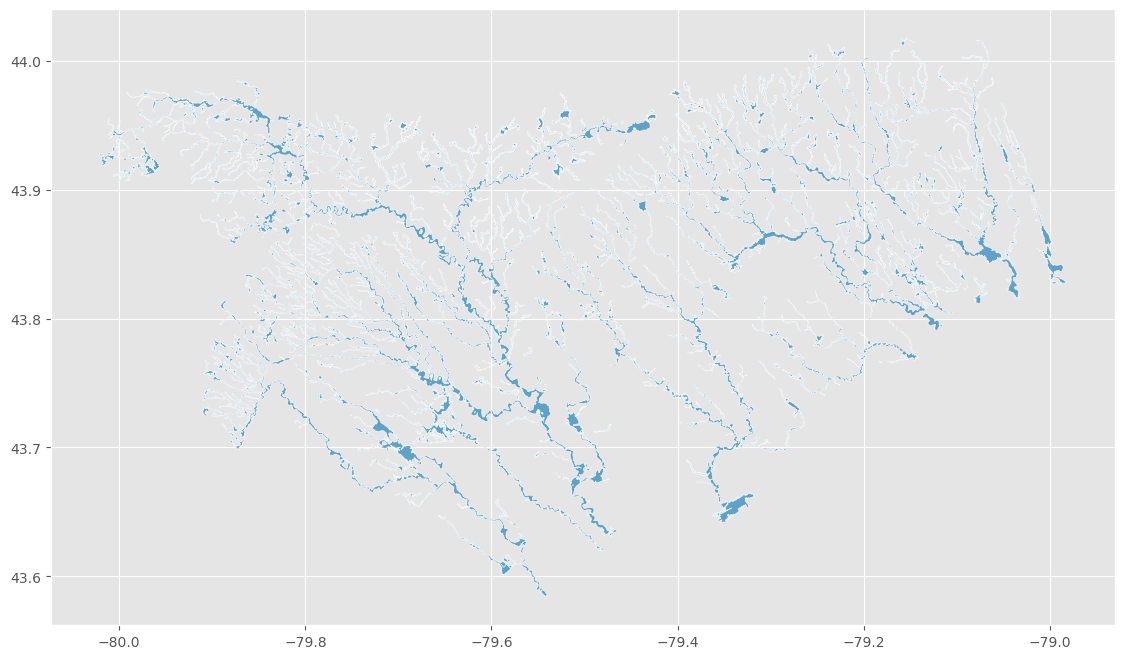

In [15]:
# Test plotting
flood_plains.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

### Neighbourhood data

In [16]:
neighbourhoods_geodata = gpd.read_file('Neighbourhoods - 4326.geojson')
neighbourhoods_geodata.head()

_id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID AREA_SHORT_CODE AREA_LONG_CODE  \
0    1  2502366      26022881               0             174            174   
1    2  2502365      26022880               0             173            173   
2    3  2502364      26022879               0             172            172   
3    4  2502363      26022878               0             171            171   
4    5  2502362      26022877               0             170            170   

                   AREA_NAME                        AREA_DESC  \
0  South Eglinton-Davisville  South Eglinton-Davisville (174)   
1              North Toronto              North Toronto (173)   
2         Dovercourt Village         Dovercourt Village (172)   
3   Junction-Wallace Emerson   Junction-Wallace Emerson (171)   
4         Yonge-Bay Corridor         Yonge-Bay Corridor (170)   

                         CLASSIFICATION CLASSIFICATION_CODE    OBJECTID  \
0  Not an NIA or Emerging Neighbourhood                  NA  17824737.0   
1  Not an NIA or Emerging Neighbourhood                  NA  17824753.0   
2  Not an NIA or Emerging Neighbourhood                  NA  17824769.0   
3  Not an NIA or Emerging Neighbourhood                  NA  17824785.0   
4  Not an NIA or Emerging Neighbourhood                  NA  17824801.0   

                                            geometry  
0  MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...  
1  MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...  
2  MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...  
3  MULTIPOLYGON (((-79.43870 43.66766, -79.43841 ...  
4  MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...

In [17]:
keep_columns = ['AREA_NAME', 'geometry']                                                #define columns to keep
neighbourhoods_geodata = neighbourhoods_geodata.filter(items=keep_columns)                            #filter df by columns
neighbourhoods_geodata.columns = ['Neighbourhood Name', 'geometry']                                         #rename columns
neighbourhoods_geodata = neighbourhoods_geodata.set_index(neighbourhoods_geodata.columns[0])

# View GeoDataFrame
neighbourhoods_geodata.head()

geometry
Neighbourhood Name                                                          
South Eglinton-Davisville  MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...
North Toronto              MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...
Dovercourt Village         MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...
Junction-Wallace Emerson   MULTIPOLYGON (((-79.43870 43.66766, -79.43841 ...
Yonge-Bay Corridor         MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...

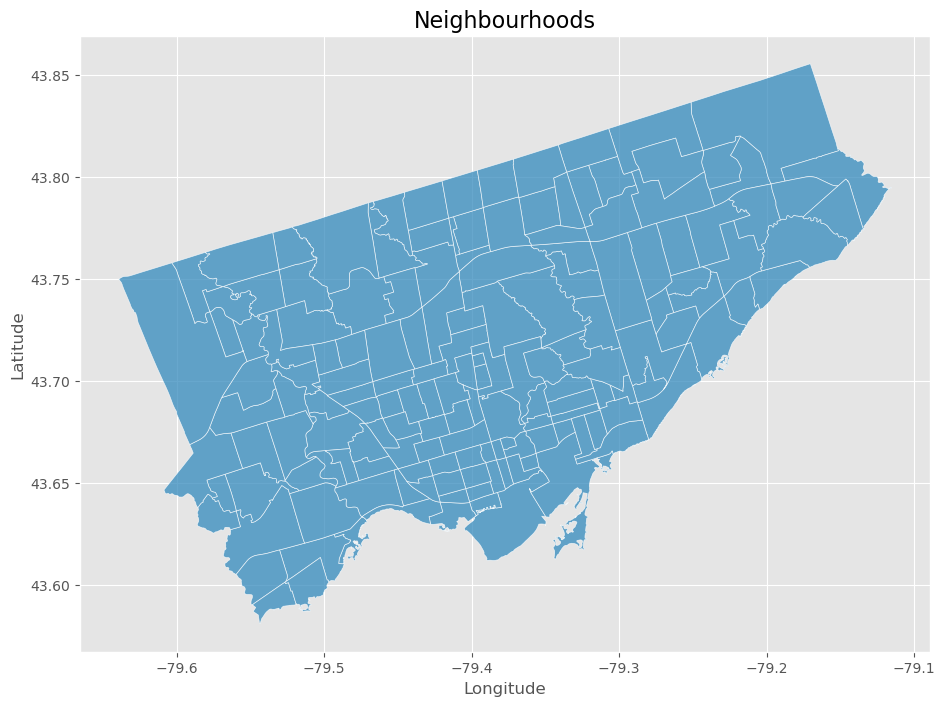

In [18]:
neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Neighbourhoods', fontsize=16)

# Display the plot
plt.show()

### Demographics Data

In [19]:
# Read the .xlsx file into a pandas DataFrame
neighbourhood_demographics = pd.read_excel("neighbourhood-profiles-2021-158-model.xlsx", engine="openpyxl")

# Print the DataFrame
neighbourhood_demographics.head()

Neighbourhood Name  \
0                               Neighbourhood Number   
1                              TSNS 2020 Designation   
2  Total - Age groups of the population - 25% sam...   
3                                      0 to 14 years   
4                                       0 to 4 years   

                 West Humber-Clairville Mount Olive-Silverstone-Jamestown  \
0                                     1                                 2   
1  Not an NIA or Emerging Neighbourhood    Neighbourhood Improvement Area   
2                                 33300                             31345   
3                                  4295                              5690   
4                                  1460                              1650   

     Thistletown-Beaumond Heights                       Rexdale-Kipling  \
0                               3                                     4   
1  Neighbourhood Improvement Area  Not an NIA or Emerging Neighbourhood   
2                            9850                                 10375   
3                            1495                                  1575   
4                             505                                   505   

                 Elms-Old Rexdale   Kingsview Village-The Westway  \
0                               5                               6   
1  Neighbourhood Improvement Area  Neighbourhood Improvement Area   
2                            9355                           22005   
3                            1610                            3915   
4                             440                            1245   

       Willowridge-Martingrove-Richview Humber Heights-Westmount  \
0                                     7                        8   
1  Not an NIA or Emerging Neighbourhood   Emerging Neighbourhood   
2                                 22445                    10005   
3                                  3500                     1370   
4                                  1065                      395   

               Edenbridge-Humber Valley  ...  \
0                                     9  ...   
1  Not an NIA or Emerging Neighbourhood  ...   
2                                 15190  ...   
3                                  2070  ...   
4                                   520  ...   

                 Harbourfront-CityPlace St Lawrence-East Bayfront-The Islands  \
0                                   165                                   166   
1  Not an NIA or Emerging Neighbourhood  Not an NIA or Emerging Neighbourhood   
2                                 28135                                 31285   
3                                  2065                                  2285   
4                                  1030                                  1045   

                       Church-Wellesley                   Downtown Yonge East  \
0                                   167                                   168   
1  Not an NIA or Emerging Neighbourhood  Not an NIA or Emerging Neighbourhood   
2                                 22320                                 17700   
3                                   895                                  1055   
4                                   495                                   480   

                         Bay-Cloverhill                    Yonge-Bay Corridor  \
0                                   169                                   170   
1  Not an NIA or Emerging Neighbourhood  Not an NIA or Emerging Neighbourhood   
2                                 16670                                 12645   
3                                   745                                   970   
4                                   370                                   500   

               Junction-Wallace Emerson                    Dovercourt Village  \
0                                   171                                   172   
1  Not an NIA or Emerging Neighbourhood  Not an

In [20]:
neighbourhood_demographics = neighbourhood_demographics.set_index(neighbourhood_demographics.columns[0])
neighbourhood_demographics.head()

West Humber-Clairville  \
Neighbourhood Name                                                                         
Neighbourhood Number                                                                   1   
TSNS 2020 Designation                               Not an NIA or Emerging Neighbourhood   
Total - Age groups of the population - 25% samp...                                 33300   
  0 to 14 years                                                                     4295   
    0 to 4 years                                                                    1460   

                                                   Mount Olive-Silverstone-Jamestown  \
Neighbourhood Name                                                                     
Neighbourhood Number                                                               2   
TSNS 2020 Designation                                 Neighbourhood Improvement Area   
Total - Age groups of the population - 25% samp...                             31345   
  0 to 14 years                                                                 5690   
    0 to 4 years                                                                1650   

                                                      Thistletown-Beaumond Heights  \
Neighbourhood Name                                                                   
Neighbourhood Number                                                             3   
TSNS 2020 Designation                               Neighbourhood Improvement Area   
Total - Age groups of the population - 25% samp...                            9850   
  0 to 14 years                                                               1495   
    0 to 4 years                                                               505   

                                                                         Rexdale-Kipling  \
Neighbourhood Name                                                                         
Neighbourhood Number                                                                   4   
TSNS 2020 Designation                               Not an NIA or Emerging Neighbourhood   
Total - Age groups of the population - 25% samp...                                 10375   
  0 to 14 years                                                                     1575   
    0 to 4 years                                                                     505   

                                                                  Elms-Old Rexdale  \
Neighbourhood Name                                                                   
Neighbourhood Number                                                             5   
TSNS 2020 Designation                               Neighbourhood Improvement Area   
Total - Age groups of the population - 25% samp...                            9355   
  0 to 14 years                                                               1610   
    0 to 4 years                                                               440   

                                                     Kingsview Village-The Westway  \
Neighbourhood Name                                                                   
Neighbourhood Number                                                             6   
TSNS 2020 Designation                               Neighbourhood Improvement Area   
Total - Age groups of the population - 25% samp...                           22005   
  0 to 14 years                                                               3915   
    0 to 4 years                                                              1245   

                                                        Willowridge-Martingrove-Richview  \
Neighbourhood Name                                                                         
Neighbourhood Number                                                                   7   
TSNS 2020 Designation                               Not an NIA or Emerging

In [21]:
len(neighbourhood_demographics.columns.tolist())


158

In [22]:
neighbourhood_demographics_transpose = neighbourhood_demographics.T
neighbourhood_demographics_transpose.head()

Neighbourhood Name                Neighbourhood Number  \
West Humber-Clairville                               1   
Mount Olive-Silverstone-Jamestown                    2   
Thistletown-Beaumond Heights                         3   
Rexdale-Kipling                                      4   
Elms-Old Rexdale                                     5   

Neighbourhood Name                                TSNS 2020 Designation  \
West Humber-Clairville             Not an NIA or Emerging Neighbourhood   
Mount Olive-Silverstone-Jamestown        Neighbourhood Improvement Area   
Thistletown-Beaumond Heights             Neighbourhood Improvement Area   
Rexdale-Kipling                    Not an NIA or Emerging Neighbourhood   
Elms-Old Rexdale                         Neighbourhood Improvement Area   

Neighbourhood Name                Total - Age groups of the population - 25% sample data  \
West Humber-Clairville                                                         33300       
Mount Olive-Silverstone-Jamestown                                              31345       
Thistletown-Beaumond Heights                                                    9850       
Rexdale-Kipling                                                                10375       
Elms-Old Rexdale                                                                9355       

Neighbourhood Name                  0 to 14 years     0 to 4 years  \
West Humber-Clairville                       4295             1460   
Mount Olive-Silverstone-Jamestown            5690             1650   
Thistletown-Beaumond Heights                 1495              505   
Rexdale-Kipling                              1575              505   
Elms-Old Rexdale                             1610              440   

Neighbourhood Name                    5 to 9 years     10 to 14 years  \
West Humber-Clairville                        1345               1485   
Mount Olive-Silverstone-Jamestown             1860               2175   
Thistletown-Beaumond Heights                   540                455   
Rexdale-Kipling                                615                455   
Elms-Old Rexdale                               480                685   

Neighbourhood Name                  15 to 64 years     15 to 19 years  \
West Humber-Clairville                       23640               1860   
Mount Olive-Silverstone-Jamestown            21490               2280   
Thistletown-Beaumond Heights                  6615                570   
Rexdale-Kipling                               6950                515   
Elms-Old Rexdale                              6355                635   

Neighbourhood Name                    20 to 24 years  ...  \
West Humber-Clairville                          3175  ...   
Mount Olive-Silverstone-Jamestown               2675  ...   
Thistletown-Beaumond Heights                     745  ...   
Rexdale-Kipling                                  715  ...   
Elms-Old Rexdale                                 685  ...   

Neighbourhood Name                  Between 9 a.m. and 11:59 a.m.  \
West Humber-Clairville                                       1665   
Mount Olive-Silverstone-Jamestown                            1145   
Thistletown-Beaumond Heights                                  395   
Rexdale-Kipling                                               425   
Elms-Old Rexdale                                              355   

Neighbourhood Name                  Between 12 p.m. and 4:59 a.m.  \
West Humber-Clairville                                       2935   
Mount Olive-Silverstone-Jamestown                            2965   
Thistletown-Beaumond Heights                                  635   
Rexdale-Kipling                                               775   
Elms-Old Rexdale                                              675   

Neighbourhood Name                Total - Eligibility for instruction in the minority official language for the population in private households born i

In [23]:
neighbourhood_demographics_transpose.shape

(158, 2603)

### Combining datasets 

In [24]:
merged_neighbourhood_df = pd.merge(neighbourhood_demographics_transpose, neighbourhoods_geodata, left_index=True, right_index=True, how='inner')
merged_neighbourhood_df.head()

Neighbourhood Number  \
West Humber-Clairville                               1   
Mount Olive-Silverstone-Jamestown                    2   
Thistletown-Beaumond Heights                         3   
Rexdale-Kipling                                      4   
Elms-Old Rexdale                                     5   

                                                  TSNS 2020 Designation  \
West Humber-Clairville             Not an NIA or Emerging Neighbourhood   
Mount Olive-Silverstone-Jamestown        Neighbourhood Improvement Area   
Thistletown-Beaumond Heights             Neighbourhood Improvement Area   
Rexdale-Kipling                    Not an NIA or Emerging Neighbourhood   
Elms-Old Rexdale                         Neighbourhood Improvement Area   

                                  Total - Age groups of the population - 25% sample data  \
West Humber-Clairville                                                         33300       
Mount Olive-Silverstone-Jamestown                                              31345       
Thistletown-Beaumond Heights                                                    9850       
Rexdale-Kipling                                                                10375       
Elms-Old Rexdale                                                                9355       

                                    0 to 14 years     0 to 4 years  \
West Humber-Clairville                       4295             1460   
Mount Olive-Silverstone-Jamestown            5690             1650   
Thistletown-Beaumond Heights                 1495              505   
Rexdale-Kipling                              1575              505   
Elms-Old Rexdale                             1610              440   

                                      5 to 9 years     10 to 14 years  \
West Humber-Clairville                        1345               1485   
Mount Olive-Silverstone-Jamestown             1860               2175   
Thistletown-Beaumond Heights                   540                455   
Rexdale-Kipling                                615                455   
Elms-Old Rexdale                               480                685   

                                    15 to 64 years     15 to 19 years  \
West Humber-Clairville                       23640               1860   
Mount Olive-Silverstone-Jamestown            21490               2280   
Thistletown-Beaumond Heights                  6615                570   
Rexdale-Kipling                               6950                515   
Elms-Old Rexdale                              6355                635   

                                      20 to 24 years  ...  \
West Humber-Clairville                          3175  ...   
Mount Olive-Silverstone-Jamestown               2675  ...   
Thistletown-Beaumond Heights                     745  ...   
Rexdale-Kipling                                  715  ...   
Elms-Old Rexdale                                 685  ...   

                                    Between 12 p.m. and 4:59 a.m.  \
West Humber-Clairville                                       2935   
Mount Olive-Silverstone-Jamestown                            2965   
Thistletown-Beaumond Heights                                  635   
Rexdale-Kipling                                               775   
Elms-Old Rexdale                                              675   

                                  Total - Eligibility for instruction in the minority official language for the population in private households born in 2003 or later - 25% sample data  \
West Humber-Clairville                                                          5430                                                                                                       
Mount Olive-Silverstone-Jamestown                                               7285                                                                                                       
Thistletown-Beaumond Heights        

In [25]:
merged_neighbourhood_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, West Humber-Clairville to South Eglinton-Davisville
Columns: 2604 entries, Neighbourhood Number to geometry
dtypes: geometry(1), object(2603)
memory usage: 3.0+ MB


In [26]:
merged_neighbourhood_df.columns.tolist()

['Neighbourhood Number',
 'TSNS 2020 Designation',
 'Total - Age groups of the population - 25% sample data',
 '  0 to 14 years',
 '    0 to 4 years',
 '    5 to 9 years',
 '    10 to 14 years',
 '  15 to 64 years',
 '    15 to 19 years',
 '    20 to 24 years',
 '    25 to 29 years',
 '    30 to 34 years',
 '    35 to 39 years',
 '    40 to 44 years',
 '    45 to 49 years',
 '    50 to 54 years',
 '    55 to 59 years',
 '    60 to 64 years',
 '  65 years and over',
 '    65 to 69 years',
 '    70 to 74 years',
 '    75 to 79 years',
 '    80 to 84 years',
 '    85 years and over',
 '      85 to 89 years',
 '      90 to 94 years',
 '      95 to 99 years',
 '      100 years and over',
 'Total - Distribution (%) of the population by broad age groups - 25% sample data',
 '  0 to 14 years',
 '  15 to 64 years',
 '  65 years and over',
 '    85 years and over',
 'Average age of the population',
 'Median age of the population',
 'Total - Persons in private households - 25% sample data',
 '  T

In [27]:
# Count occurrences of the column name in the DataFrame columns
column_name = '  $10,000 to $14,999'
count = merged_neighbourhood_df.columns.to_list().count(column_name)

print(f"The column '{column_name}' appears {count} times in merged_neighbourhood_df.")


The column '  $10,000 to $14,999' appears 2 times in merged_neighbourhood_df.


In [28]:
# Rename columns to include their column index
merged_neighbourhood_df.columns = [
    f"{col} ({i})" for i, col in enumerate(merged_neighbourhood_df.columns)
]

# Display the first few renamed columns to verify
print("Renamed columns:")
print(merged_neighbourhood_df.columns[:10])  # Display first 10 columns for verification


Renamed columns:
Index(['Neighbourhood Number (0)', 'TSNS 2020 Designation (1)',
       'Total - Age groups of the population - 25% sample data (2)',
       '  0 to 14 years (3)', '    0 to 4 years (4)', '    5 to 9 years (5)',
       '    10 to 14 years (6)', '  15 to 64 years (7)',
       '    15 to 19 years (8)', '    20 to 24 years (9)'],
      dtype='object')


In [29]:
merged_neighbourhood_df.columns.tolist()

['Neighbourhood Number (0)',
 'TSNS 2020 Designation (1)',
 'Total - Age groups of the population - 25% sample data (2)',
 '  0 to 14 years (3)',
 '    0 to 4 years (4)',
 '    5 to 9 years (5)',
 '    10 to 14 years (6)',
 '  15 to 64 years (7)',
 '    15 to 19 years (8)',
 '    20 to 24 years (9)',
 '    25 to 29 years (10)',
 '    30 to 34 years (11)',
 '    35 to 39 years (12)',
 '    40 to 44 years (13)',
 '    45 to 49 years (14)',
 '    50 to 54 years (15)',
 '    55 to 59 years (16)',
 '    60 to 64 years (17)',
 '  65 years and over (18)',
 '    65 to 69 years (19)',
 '    70 to 74 years (20)',
 '    75 to 79 years (21)',
 '    80 to 84 years (22)',
 '    85 years and over (23)',
 '      85 to 89 years (24)',
 '      90 to 94 years (25)',
 '      95 to 99 years (26)',
 '      100 years and over (27)',
 'Total - Distribution (%) of the population by broad age groups - 25% sample data (28)',
 '  0 to 14 years (29)',
 '  15 to 64 years (30)',
 '  65 years and over (31)',
 '    85

In [30]:
merged_neighbourhood_df.tail()

Neighbourhood Number (0)  \
Yonge-Bay Corridor                             170   
Junction-Wallace Emerson                       171   
Dovercourt Village                             172   
North Toronto                                  173   
South Eglinton-Davisville                      174   

                                      TSNS 2020 Designation (1)  \
Yonge-Bay Corridor         Not an NIA or Emerging Neighbourhood   
Junction-Wallace Emerson   Not an NIA or Emerging Neighbourhood   
Dovercourt Village         Not an NIA or Emerging Neighbourhood   
North Toronto              Not an NIA or Emerging Neighbourhood   
South Eglinton-Davisville  Not an NIA or Emerging Neighbourhood   

                          Total - Age groups of the population - 25% sample data (2)  \
Yonge-Bay Corridor                                                     12645           
Junction-Wallace Emerson                                               23180           
Dovercourt Village                                                     12380           
North Toronto                                                          15885           
South Eglinton-Davisville                                              22735           

                            0 to 14 years (3)     0 to 4 years (4)  \
Yonge-Bay Corridor                        970                  500   
Junction-Wallace Emerson                 3075                 1135   
Dovercourt Village                       1365                  445   
North Toronto                            1315                  535   
South Eglinton-Davisville                2190                  910   

                              5 to 9 years (5)     10 to 14 years (6)  \
Yonge-Bay Corridor                         270                    200   
Junction-Wallace Emerson                  1020                    925   
Dovercourt Village                         430                    490   
North Toronto                              390                    390   
South Eglinton-Davisville                  670                    610   

                            15 to 64 years (7)     15 to 19 years (8)  \
Yonge-Bay Corridor                       10820                    340   
Junction-Wallace Emerson                 17200                    750   
Dovercourt Village                        9040                    460   
North Toronto                            12780                    465   
South Eglinton-Davisville                17495                    575   

                              20 to 24 years (9)  ...  \
Yonge-Bay Corridor                          1825  ...   
Junction-Wallace Emerson                    1185  ...   
Dovercourt Village                           640  ...   
North Toronto                                960  ...   
South Eglinton-Davisville                   1115  ...   

                            Between 12 p.m. and 4:59 a.m. (2594)  \
Yonge-Bay Corridor                                           330   
Junction-Wallace Emerson                                    1105   
Dovercourt Village                                           570   
North Toronto                                                550   
South Eglinton-Davisville                                    730   

                          Total - Eligibility for instruction in the minority official language for the population in private households born in 2003 or later - 25% sample data (2595)  \
Yonge-Bay Corridor                                                      1075                                                                                                              
Junction-Wallace Emerson                                                3580                                                                                                              
Dovercourt Village                                                      1665                                                                                 

Dataframe is now combined and ready for feature analysis

In [31]:
intersection = gpd.overlay(flood_line, neighbourhoods_geodata, how='intersection')

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the neighbourhoods
neighbourhoods_geodata.plot(ax=ax, edgecolor='w', alpha=0.75)

# Plot the flood line only if it intersects the neighbourhoods
if not intersection.empty:
    intersection.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains Intersection')

# Labeling the axes
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)

# Add title
plt.title('Flood Plains and Neighbourhoods', fontsize=20)

# Show the plot
plt.show()

NameError: name 'flood_line' is not defined

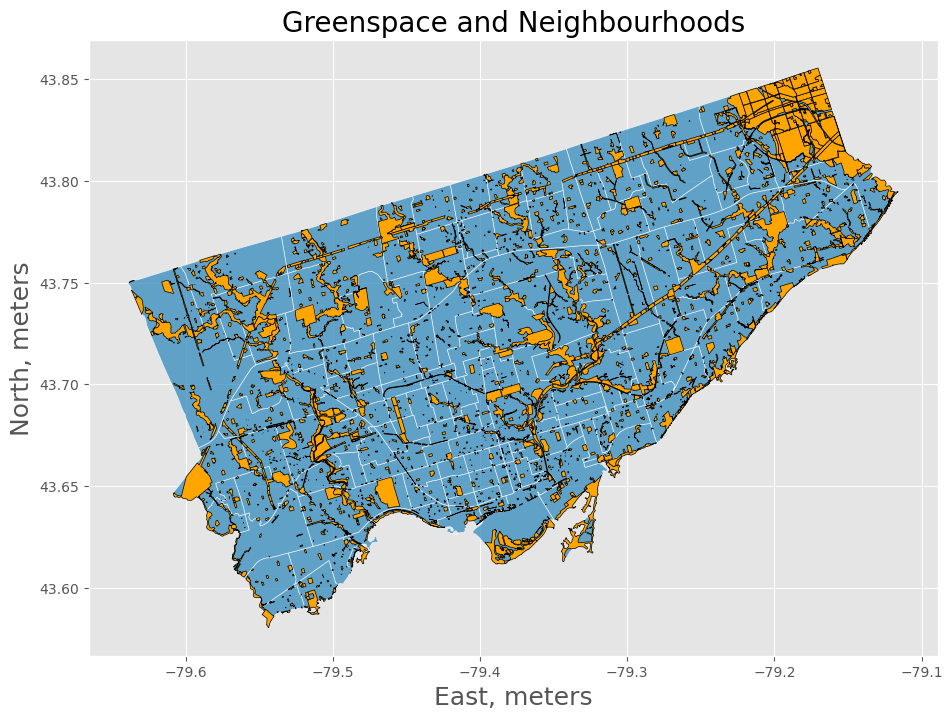

In [32]:
ax = neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)                       #plot size and colour
greenspace.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains')  
plt.xlabel('East, meters', fontsize=18)                                                    #axses labels
plt.ylabel('North, meters', fontsize=18) 
plt.title('Greenspace and Neighbourhoods', fontsize=20)                          #title
plt.show()

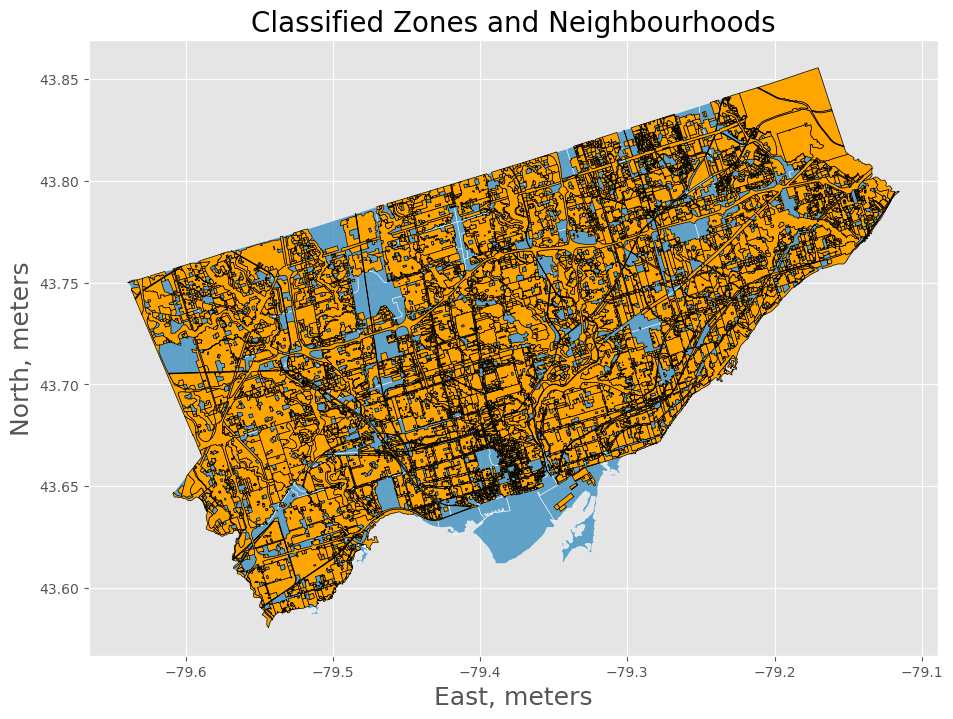

In [33]:
ax = neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)                       #plot size and colour
zones_geodata.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains')  
plt.xlabel('East, meters', fontsize=18)                                                    #axses labels
plt.ylabel('North, meters', fontsize=18) 
plt.title('Classified Zones and Neighbourhoods', fontsize=20)                          #title
plt.show()

In [87]:
merged_gdf.shape

(158, 3)

/opt/conda/lib/python3.11/site-packages/mapclassify/classifiers.py:461: RuntimeWarning: invalid value encountered in greater
  binIds += (x > _l) * (x <= r) * k
/opt/conda/lib/python3.11/site-packages/mapclassify/classifiers.py:461: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > _l) * (x <= r) * k


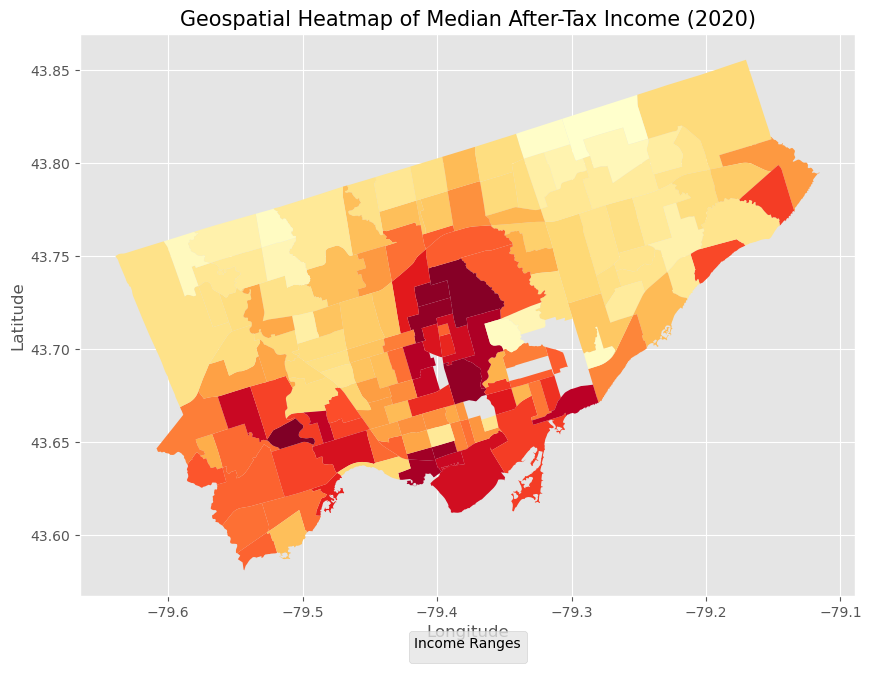

In [34]:
income_data = neighbourhood_demographics_transpose[["    Median total income in 2020  among recipients ($)"]]
merged_gdf = neighbourhoods_geodata.join(income_data)

classifier = mapclassify.Quantiles(merged_gdf["    Median total income in 2020  among recipients ($)"], k=4)
merged_gdf["income_bins"] = classifier.yb  # Add the classification to the GeoDataFrame


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with the selected income column for color mapping
merged_gdf.plot(column="    Median total income in 2020  among recipients ($)",
                ax=ax,
                cmap='YlOrRd',  # Choose the color map, e.g., 'viridis', 'coolwarm', etc.
                legend_kwds={
                    'label': "Median After-Tax Income ($)",  # Label for the legend
                    'orientation': "horizontal",  # Orientation of the legend
                    'bbox_to_anchor': (0.5, -0.05),  # Position the legend
                    'loc': 'upper center'  # Position legend in the center
                })

# Customize the legend
# Create a list of the bin labels based on the classification
bin_labels = [f"{round(classifier.bins[i], 2)} - {round(classifier.bins[i + 1], 2)}"
              for i in range(len(classifier.bins) - 1)]

# Add a legend with the appropriate bin ranges
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, bin_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, title="Income Ranges")

# Add title and labels
ax.set_title("Geospatial Heatmap of Median After-Tax Income (2020)", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()


Now we shall only retrieve the columns that pertain to the vulnerability index.

In [35]:
# Define the complete grouped columns (replace with your full column lists)
grouped_columns = {
    "Demographics": [
        'Total - Age groups of the population - 25% sample data (2)',
        '  0 to 14 years (3)',
        '  15 to 64 years (7)',
        '  65 years and over (18)',
        'Average age of the population (33)',

    ],
    "Family Composition": [
        'Total - Persons in private households - 25% sample data (35)',
        '  Total - Persons in census families (36)',
        '    Married spouses or common-law partners (37)',
        '    Parents in one-parent families (38)',
        '    Children (39)',
        '      In a two-parent family (40)',
        '      In a one-parent family (41)',
        '  Total - Persons not in census families in private households - 25% sample data (42)',

    ],
    "Income": [
        'Total - Income statistics in 2020 for the population aged 15 years and over in private households - 25% sample data (60)',
        '  Number of after-tax income recipients aged 15 years and over in private households in 2020 - 25% sample data (64)',
        '    Median after-tax income in 2020 among recipients ($) (65)',
        '    Average after-tax income in 2020 among recipients ($) (66)',
        'Total - After-tax income groups in 2020 for the population aged 15 years and over in private households - 25% sample data (105)',
        '  Without after-tax income (106)',
        '  With after-tax income (107)',
        '    Under $10,000 (including loss) (108)',
        '    $10,000 to $19,999 (109)',
        '    $20,000 to $29,999 (110)',
        '    $30,000 to $39,999 (111)',
        '    $40,000 to $49,999 (112)',
        '    $50,000 to $59,999 (113)',
        '    $60,000 to $69,999 (114)',
        '    $70,000 to $79,999 (115)',
        '    $80,000 to $89,999 (116)',
        '    $90,000 to $99,999 (117)',
        '    $100,000 and over (118)',
        '      $100,000 to $124,999 (119)',
        '      $125,000 and over (120)',
    ],
    "Housing": [
        'Total - Private households by tenure - 25% sample data (298)',
        '  Owner (299)',
        '  Renter (300)',
        '  Dwelling provided by the local government, First Nation or Indian band (301)',
        'Total - Occupied private dwellings by condominium status - 25% sample data (302)',
        '  Condominium (303)',
        '  Not condominium (304)',
        'Total - Occupied private dwellings by number of rooms - 25% sample data (311)',
        '  1 to 4 rooms (312)',
        '  5 rooms (313)',
        '  6 rooms (314)',
        '  7 rooms (315)',
        '  8 or more rooms (316)',
        'Average number of rooms per dwelling (317)',
    ],
    "Condition": [
        'Total - Private households by housing suitability - 25% sample data (321)',
        '  Suitable (322)',
        '  Not suitable (323)',
        'Total - Occupied private dwellings by period of construction - 25% sample data (324)',
        '  1960 or before (325)',
        '  1961 to 1980 (326)',
        '  1981 to 1990 (327)',
        '  1991 to 2000 (328)',
        '  2001 to 2005 (329)',
        '  2006 to 2010 (330)',
        '  2011 to 2015 (331)',
        '  2016 to 2021 (332)',
        'Total - Occupied private dwellings by dwelling condition - 25% sample data (333)',
        '  Only regular maintenance and minor repairs needed (334)',
        '  Major repairs needed (335)'
        "  Total - Households 'spending 30% or more of income on shelter costs' or 'not suitable' or 'major repairs needed' (350)",
            ],
    "Language": [
        'Total - Knowledge of official languages for the population in private households - 25% sample data (426)',
        '  English only (427)',
        '  French only (428)',
        '  English and French (429)',
        '  Neither English nor French (430)'
    ],
    
}

# Ensure the required columns are included in all DataFrames
common_columns = ['Neighbourhood Number (0)', 'TSNS 2020 Designation (1)', 'geometry (2603)']

# Create DataFrames for each group
dataframes = {}
for group_name, columns in grouped_columns.items():
    # Combine common columns with group-specific ones
    selected_columns = common_columns + columns
    # Ensure the selected columns exist in the DataFrame
    selected_columns = [col for col in selected_columns if col in merged_neighbourhood_df.columns]
    # Create the DataFrame
    dataframes[group_name] = merged_neighbourhood_df[selected_columns]

# Example: Access a specific group DataFrame
print("Demographics DataFrame:")
dataframes["Demographics"].head()


Demographics DataFrame:


Neighbourhood Number (0)  \
West Humber-Clairville                                   1   
Mount Olive-Silverstone-Jamestown                        2   
Thistletown-Beaumond Heights                             3   
Rexdale-Kipling                                          4   
Elms-Old Rexdale                                         5   

                                              TSNS 2020 Designation (1)  \
West Humber-Clairville             Not an NIA or Emerging Neighbourhood   
Mount Olive-Silverstone-Jamestown        Neighbourhood Improvement Area   
Thistletown-Beaumond Heights             Neighbourhood Improvement Area   
Rexdale-Kipling                    Not an NIA or Emerging Neighbourhood   
Elms-Old Rexdale                         Neighbourhood Improvement Area   

                                                                     geometry (2603)  \
West Humber-Clairville             MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ...   
Mount Olive-Silverstone-Jamestown  MULTIPOLYGON (((-79.57938 43.76222, -79.57925 ...   
Thistletown-Beaumond Heights       MULTIPOLYGON (((-79.56226 43.74373, -79.56234 ...   
Rexdale-Kipling                    MULTIPOLYGON (((-79.56419 43.71229, -79.56670 ...   
Elms-Old Rexdale                   MULTIPOLYGON (((-79.54677 43.73156, -79.54632 ...   

                                  Total - Age groups of the population - 25% sample data (2)  \
West Humber-Clairville                                                         33300           
Mount Olive-Silverstone-Jamestown                                              31345           
Thistletown-Beaumond Heights                                                    9850           
Rexdale-Kipling                                                                10375           
Elms-Old Rexdale                                                                9355           

                                    0 to 14 years (3)   15 to 64 years (7)  \
West Humber-Clairville                           4295                23640   
Mount Olive-Silverstone-Jamestown                5690                21490   
Thistletown-Beaumond Heights                     1495                 6615   
Rexdale-Kipling                                  1575                 6950   
Elms-Old Rexdale                                 1610                 6355   

                                    65 years and over (18)  \
West Humber-Clairville                                5360   
Mount Olive-Silverstone-Jamestown                     4170   
Thistletown-Beaumond Heights                          1740   
Rexdale-Kipling                                       1850   
Elms-Old Rexdale                                      1390   

                                  Average age of the population (33)  
West Humber-Clairville                                          40.5  
Mount Olive-Silverstone-Jamestown                               37.8  
Thistletown-Beaumond Heights                                      41  
Rexdale-Kipling                                                 41.9  
Elms-Old Rexdale                                                39.6

In [36]:
# Ensure the required columns are included in all DataFrames
common_columns = ['Neighbourhood Number (0)', 'TSNS 2020 Designation (1)', 'geometry (2603)']

# Initialize a DataFrame with the common columns
big_dataframe = merged_neighbourhood_df[common_columns].copy()

# Iterate over the grouped columns and merge into the big DataFrame
for group_name, columns in grouped_columns.items():
    # Select only the columns present in merged_neighbourhood_df
    selected_columns = [col for col in columns if col in merged_neighbourhood_df.columns]
    # Extract the group-specific DataFrame
    group_df = merged_neighbourhood_df[selected_columns]
    # Concatenate the group DataFrame along columns
    big_dataframe = pd.concat([big_dataframe, group_df], axis=1)

# Output the combined big DataFrame
print("Big DataFrame:")
big_dataframe.head()


Big DataFrame:


Neighbourhood Number (0)  \
West Humber-Clairville                                   1   
Mount Olive-Silverstone-Jamestown                        2   
Thistletown-Beaumond Heights                             3   
Rexdale-Kipling                                          4   
Elms-Old Rexdale                                         5   

                                              TSNS 2020 Designation (1)  \
West Humber-Clairville             Not an NIA or Emerging Neighbourhood   
Mount Olive-Silverstone-Jamestown        Neighbourhood Improvement Area   
Thistletown-Beaumond Heights             Neighbourhood Improvement Area   
Rexdale-Kipling                    Not an NIA or Emerging Neighbourhood   
Elms-Old Rexdale                         Neighbourhood Improvement Area   

                                                                     geometry (2603)  \
West Humber-Clairville             MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ...   
Mount Olive-Silverstone-Jamestown  MULTIPOLYGON (((-79.57938 43.76222, -79.57925 ...   
Thistletown-Beaumond Heights       MULTIPOLYGON (((-79.56226 43.74373, -79.56234 ...   
Rexdale-Kipling                    MULTIPOLYGON (((-79.56419 43.71229, -79.56670 ...   
Elms-Old Rexdale                   MULTIPOLYGON (((-79.54677 43.73156, -79.54632 ...   

                                  Total - Age groups of the population - 25% sample data (2)  \
West Humber-Clairville                                                         33300           
Mount Olive-Silverstone-Jamestown                                              31345           
Thistletown-Beaumond Heights                                                    9850           
Rexdale-Kipling                                                                10375           
Elms-Old Rexdale                                                                9355           

                                    0 to 14 years (3)   15 to 64 years (7)  \
West Humber-Clairville                           4295                23640   
Mount Olive-Silverstone-Jamestown                5690                21490   
Thistletown-Beaumond Heights                     1495                 6615   
Rexdale-Kipling                                  1575                 6950   
Elms-Old Rexdale                                 1610                 6355   

                                    65 years and over (18)  \
West Humber-Clairville                                5360   
Mount Olive-Silverstone-Jamestown                     4170   
Thistletown-Beaumond Heights                          1740   
Rexdale-Kipling                                       1850   
Elms-Old Rexdale                                      1390   

                                  Average age of the population (33)  \
West Humber-Clairville                                          40.5   
Mount Olive-Silverstone-Jamestown                               37.8   
Thistletown-Beaumond Heights                                      41   
Rexdale-Kipling                                                 41.9   
Elms-Old Rexdale                                                39.6   

                                  Total - Persons in private households - 25% sample data (35)  \
West Humber-Clairville                                                         33300             
Mount Olive-Silverstone-Jamestown                                              31345             
Thistletown-Beaumond Heights                                                    9850             
Rexdale-Kipling                                                                10375             
Elms-Old Rexdale                                                                9355             

                                    Total - Persons in census families (36)  \
West Humber-Clairville                                                26490   
Mount Olive-Silverstone-Jamestown                                     26335   
Thi

In [89]:
big_dataframe.shape

(151, 41)

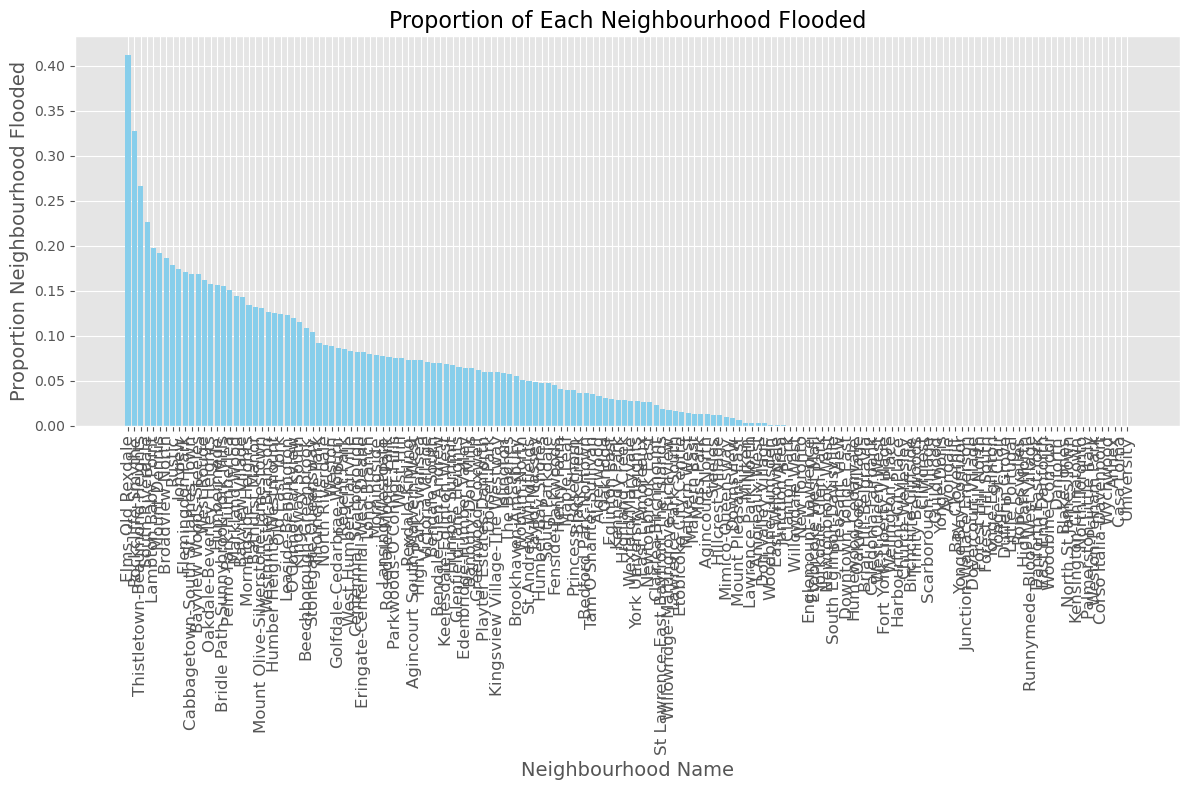

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace this with the path to your GeoJSON file
file_path = r"Neighbourhoods and Flooding.geojson"

# Load the GeoJSON file into a GeoDataFrame
flood_df = gpd.read_file(file_path)

# Create a bar chart of 'Neighbourhood_name' and 'Proportion Neighbourhood flooded'
plt.figure(figsize=(12, 8))
plt.bar(flood_df['Neighbourhood_name'], flood_df['Proportion Neighbourhood flooded'], color='skyblue')

# Customize the plot
plt.title('Proportion of Each Neighbourhood Flooded', fontsize=16)
plt.xlabel('Neighbourhood Name', fontsize=14)
plt.ylabel('Proportion Neighbourhood Flooded', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [91]:
flood_df.shape

(158, 7)

In [39]:
# Check if the required columns exist in flood_df
if 'Neighbourhood_name' in flood_df.columns and 'Proportion Neighbourhood flooded' in flood_df.columns:
    # Merge the Proportion Neighbourhood flooded column into the big DataFrame
    big_dataframe = big_dataframe.merge(
        flood_df[['Neighbourhood_name', 'Proportion Neighbourhood flooded']],
        how='left',
        left_index=True,  # Match based on the index of big_dataframe
        right_on='Neighbourhood_name'  # Match with Neighbourhood_name in flood_df
    )
    # Drop the redundant Neighbourhood_name column from flood_df
    big_dataframe = big_dataframe.drop(columns=['Neighbourhood_name'])
else:
    print("Error: flood_df does not have the required columns.")

# Output the updated big DataFrame
print("Big DataFrame with Proportion Neighbourhood flooded column:")
big_dataframe.head()


Big DataFrame with Proportion Neighbourhood flooded column:


Neighbourhood Number (0)             TSNS 2020 Designation (1)  \
35                        1  Not an NIA or Emerging Neighbourhood   
21                        2        Neighbourhood Improvement Area   
2                         3        Neighbourhood Improvement Area   
44                        4  Not an NIA or Emerging Neighbourhood   
0                         5        Neighbourhood Improvement Area   

                                      geometry (2603)  \
35  MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ...   
21  MULTIPOLYGON (((-79.57938 43.76222, -79.57925 ...   
2   MULTIPOLYGON (((-79.56226 43.74373, -79.56234 ...   
44  MULTIPOLYGON (((-79.56419 43.71229, -79.56670 ...   
0   MULTIPOLYGON (((-79.54677 43.73156, -79.54632 ...   

   Total - Age groups of the population - 25% sample data (2)  \
35                                              33300           
21                                              31345           
2                                                9850           
44                                              10375           
0                                                9355           

     0 to 14 years (3)   15 to 64 years (7)   65 years and over (18)  \
35                4295                23640                     5360   
21                5690                21490                     4170   
2                 1495                 6615                     1740   
44                1575                 6950                     1850   
0                 1610                 6355                     1390   

   Average age of the population (33)  \
35                               40.5   
21                               37.8   
2                                  41   
44                               41.9   
0                                39.6   

   Total - Persons in private households - 25% sample data (35)  \
35                                              33300             
21                                              31345             
2                                                9850             
44                                              10375             
0                                                9355             

     Total - Persons in census families (36)  ...   2011 to 2015 (331)  \
35                                     26490  ...                  350   
21                                     26335  ...                  100   
2                                       8045  ...                   50   
44                                      8235  ...                   35   
0                                       7800  ...                   10   

     2016 to 2021 (332)  \
35                  380   
21                  100   
2                    30   
44                   15   
0                     0   

   Total - Occupied private dwellings by dwelling condition - 25% sample data (333)  \
35                                              10700                                 
21                                               9740                                 
2                                                3245                                 
44                                               3945                                 
0                                                3195                                 

     Only regular maintenance and minor repairs needed (334)  \
35                                              10230          
21                                               8650          
2                                                3045          
44                                               3655          
0                                                2810          

   Total - Knowledge of official languages for the population in private households - 25% sample data (426)  \
35                                              33295                                                         
21                               

In [90]:
big_dataframe.shape

(151, 41)

In [40]:
# Check which columns are numeric
numeric_columns = big_dataframe.select_dtypes(include=[np.number]).columns
print("Numeric columns in the DataFrame:", numeric_columns)

# If numeric columns exist, calculate correlations
if len(numeric_columns) > 1:  # More than just 'Proportion Neighbourhood flooded'
    correlation_with_flooded = big_dataframe[numeric_columns].corr()['Proportion Neighbourhood flooded'].sort_values(ascending=False)
    
    # Convert to DataFrame for readability
    correlation_table = correlation_with_flooded.reset_index()
    correlation_table.columns = ['Column', 'Correlation with Proportion Neighbourhood Flooded']
    
    print(correlation_table)
else:
    print("No additional numeric columns found for correlation analysis.")


Numeric columns in the DataFrame: Index(['Proportion Neighbourhood flooded'], dtype='object')
No additional numeric columns found for correlation analysis.


In [41]:
# Attempt to convert all object columns to float
for col in big_dataframe.select_dtypes(include=['object']).columns:
    try:
        # Convert to float in place
        big_dataframe[col] = big_dataframe[col].astype(float)
    except ValueError:
        print(f"Column '{col}' contains non-numeric data and could not be converted to float.")

# Check the data types of the updated DataFrame
print("Updated DataFrame data types:")
print(big_dataframe.dtypes)

big_dataframe.info()

Column 'TSNS 2020 Designation (1)' contains non-numeric data and could not be converted to float.
Updated DataFrame data types:
Neighbourhood Number (0)                                       float64
TSNS 2020 Designation (1)                                       object
geometry (2603)                                               geometry
Total - Age groups of the population - 25% sample data (2)     float64
  0 to 14 years (3)                                            float64
                                                                ...   
  English only (427)                                           float64
  French only (428)                                            float64
  English and French (429)                                     float64
  Neither English nor French (430)                             float64
Proportion Neighbourhood flooded                               float64
Length: 70, dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 35 to 1

/tmp/ipykernel_87/1229513085.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


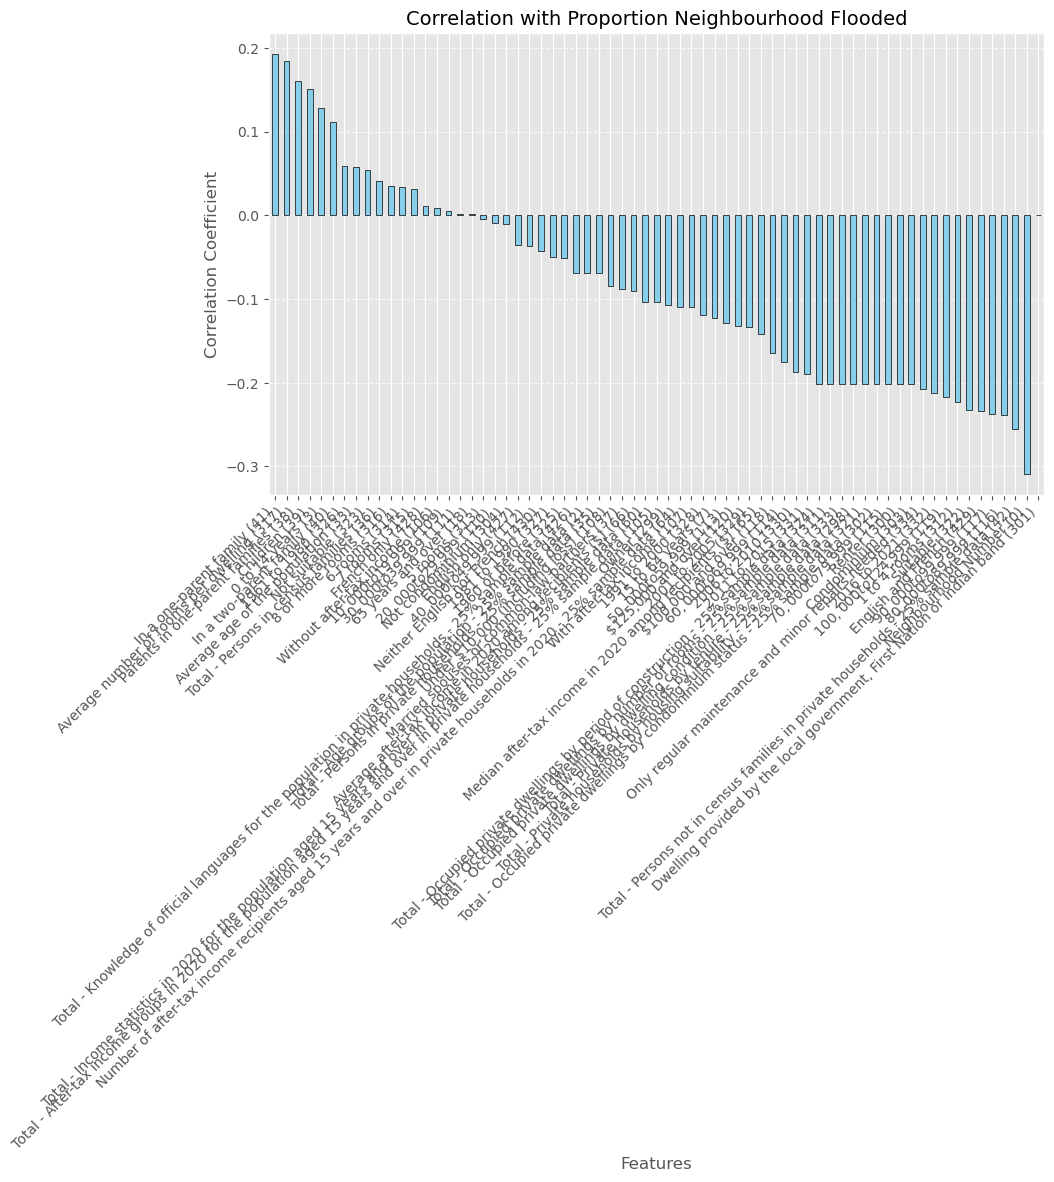

In [42]:
import matplotlib.pyplot as plt

# Ensure 'Proportion Neighbourhood flooded' exists in the DataFrame
if 'Proportion Neighbourhood flooded' in big_dataframe.columns:
    # Select only numeric columns
    numeric_columns = big_dataframe.select_dtypes(include=[np.number])
    
    if 'Proportion Neighbourhood flooded' in numeric_columns.columns:
        # Calculate correlations with 'Proportion Neighbourhood flooded'
        correlation_with_flooded = numeric_columns.corr()['Proportion Neighbourhood flooded'].sort_values(ascending=False)
        
        # Drop self-correlation for better visualization
        correlation_with_flooded = correlation_with_flooded.drop('Proportion Neighbourhood flooded', errors='ignore')
        
        # Plot the correlations as a bar chart
        plt.figure(figsize=(10, 6))
        correlation_with_flooded.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title('Correlation with Proportion Neighbourhood Flooded', fontsize=14)
        plt.ylabel('Correlation Coefficient', fontsize=12)
        plt.xlabel('Features', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("The column 'Proportion Neighbourhood flooded' is not numeric.")
else:
    print("The column 'Proportion Neighbourhood flooded' does not exist in the DataFrame.")


In [43]:
# Ensure 'Proportion Neighbourhood flooded' exists in the DataFrame
if 'Proportion Neighbourhood flooded' in big_dataframe.columns:
    # Select only numeric columns
    numeric_columns = big_dataframe.select_dtypes(include=[np.number])
    
    # Check if the target column is in the numeric DataFrame
    if 'Proportion Neighbourhood flooded' in numeric_columns.columns:
        # Calculate correlations with 'Proportion Neighbourhood flooded'
        correlation_with_flooded = numeric_columns.corr()['Proportion Neighbourhood flooded']
        
        # Identify columns with magnitude of correlation >= 0.1
        columns_to_keep = correlation_with_flooded[correlation_with_flooded.abs() >= 0.1].index
        
        # Keep only these columns in the DataFrame
        big_dataframe = big_dataframe[columns_to_keep]
        
        print(f"Columns with |correlation| >= 0.1 kept: {list(columns_to_keep)}")
    else:
        print("The column 'Proportion Neighbourhood flooded' is not numeric.")
else:
    print("The column 'Proportion Neighbourhood flooded' does not exist in the DataFrame.")


Columns with |correlation| >= 0.1 kept: ['Neighbourhood Number (0)', '  0 to 14 years (3)', '  15 to 64 years (7)', '    Parents in one-parent families (38)', '    Children (39)', '      In a two-parent family (40)', '      In a one-parent family (41)', '  Total - Persons not in census families in private households - 25% sample data (42)', 'Total - Income statistics in 2020 for the population aged 15 years and over in private households - 25% sample data (60)', '  Number of after-tax income recipients aged 15 years and over in private households in 2020 - 25% sample data (64)', '    Median after-tax income in 2020 among recipients ($) (65)', 'Total - After-tax income groups in 2020 for the population aged 15 years and over in private households - 25% sample data (105)', '  With after-tax income (107)', '    $50,000 to $59,999 (113)', '    $60,000 to $69,999 (114)', '    $70,000 to $79,999 (115)', '    $80,000 to $89,999 (116)', '    $90,000 to $99,999 (117)', '    $100,000 and over (1

/tmp/ipykernel_87/2792655647.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


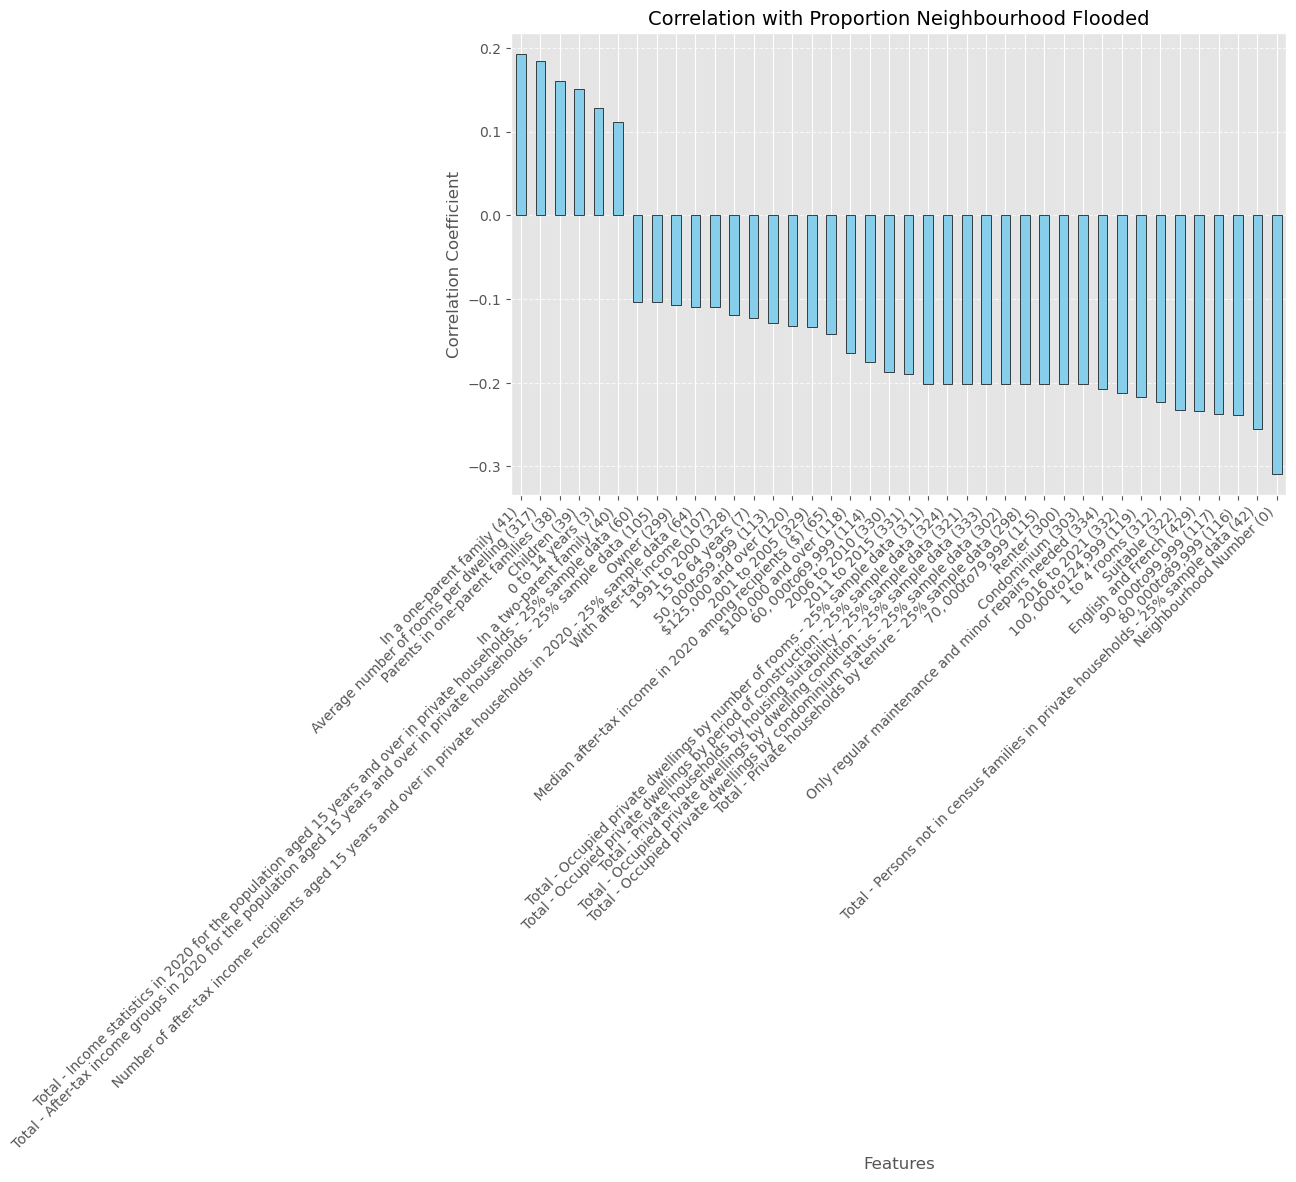

In [44]:
import matplotlib.pyplot as plt

# Ensure 'Proportion Neighbourhood flooded' exists in the DataFrame
if 'Proportion Neighbourhood flooded' in big_dataframe.columns:
    # Select only numeric columns
    numeric_columns = big_dataframe.select_dtypes(include=[np.number])
    
    if 'Proportion Neighbourhood flooded' in numeric_columns.columns:
        # Calculate correlations with 'Proportion Neighbourhood flooded'
        correlation_with_flooded = numeric_columns.corr()['Proportion Neighbourhood flooded'].sort_values(ascending=False)
        
        # Drop self-correlation for better visualization
        correlation_with_flooded = correlation_with_flooded.drop('Proportion Neighbourhood flooded', errors='ignore')
        
        # Plot the correlations as a bar chart
        plt.figure(figsize=(10, 6))
        correlation_with_flooded.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title('Correlation with Proportion Neighbourhood Flooded', fontsize=14)
        plt.ylabel('Correlation Coefficient', fontsize=12)
        plt.xlabel('Features', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("The column 'Proportion Neighbourbhood flooded' is not numeric.")
else:
    print("The column 'Proportion Neighbourhood flooded' does not exist in the DataFrame.")


From this, we can conclude that there is no correlation of the demographic or other population data with the proportion of area flooded within a neighborhood. 
This acknowledges that there are no specific groups that are perpously affected by flooding; the susceptability of being affected by flooding is driven by geographical location, and proximity to flood planes. 

Next step is to create a vulnerability index.

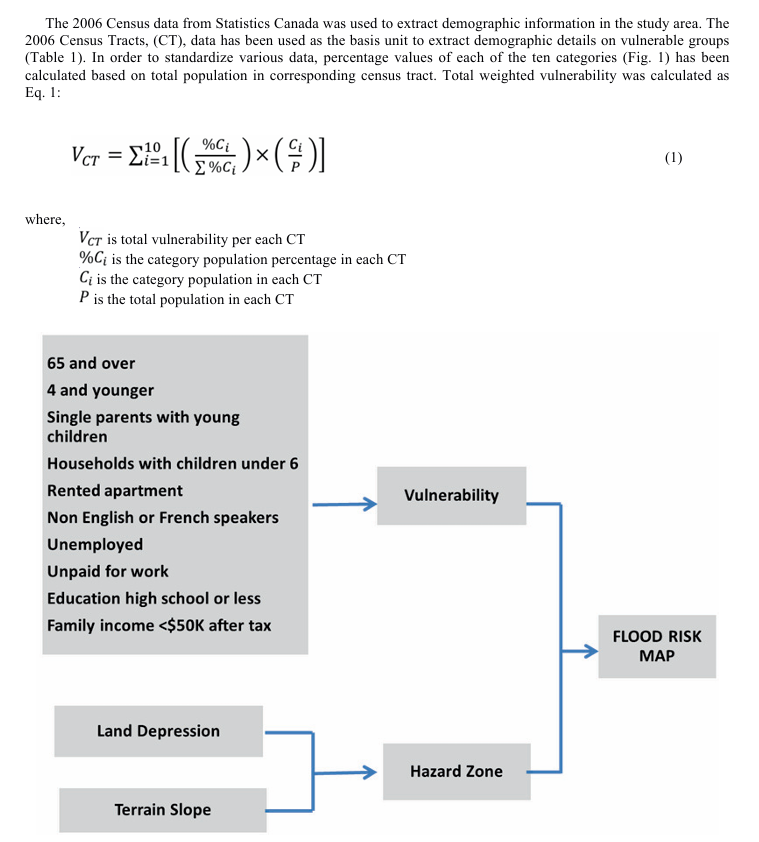

In [102]:

columns_to_sum = [
    '  Under $5,000 (279)',
    '  $5,000 to $9,999 (280)',
    '  $10,000 to $14,999 (281)',
    '  $15,000 to $19,999 (282)',
    '  $20,000 to $24,999 (283)',
    '  $25,000 to $29,999 (284)',
    '  $30,000 to $34,999 (285)',
    '  $35,000 to $39,999 (286)',
    '  $40,000 to $44,999 (287)',
    '  $45,000 to $49,999 (288)'
]

# Create the new column by summing the specified columns
merged_neighbourhood_df['Family Income under 50k'] = merged_neighbourhood_df[columns_to_sum].sum(axis=1)

vul_index_df = merged_neighbourhood_df[[ 
    '  65 years and over (18)',
    '  0 to 14 years (3)', #No data for 4 and younger, so this is the closest column to the data
    '    Parents in one-parent families (38)',
    '    Children (39)', # Data does not specify age of children, so will take populations including children
    '  Renter (300)',
    '  French only (428)',
    '  English and French (429)',
    '  Neither English nor French (430)',
    '  Without total income (90)', # Unemployed
    '  Gini index on adjusted household total income (211)', # in place for unpaid work to give measure of inequality
    # No data on education level
    'Total - Household after-tax income groups in 2020 for private households - 25% sample data (278)',
    'Family Income under 50k',
    # These three columns are needed to map the data
    'Neighbourhood Number (0)', 
    'TSNS 2020 Designation (1)', 
    'geometry (2603)',
    'Total - Age groups of the population - 25% sample data (2)' # Total Population
]]

vul_index_df.head()

65 years and over (18)  \
West Humber-Clairville                                5360   
Mount Olive-Silverstone-Jamestown                     4170   
Thistletown-Beaumond Heights                          1740   
Rexdale-Kipling                                       1850   
Elms-Old Rexdale                                      1390   

                                    0 to 14 years (3)  \
West Humber-Clairville                           4295   
Mount Olive-Silverstone-Jamestown                5690   
Thistletown-Beaumond Heights                     1495   
Rexdale-Kipling                                  1575   
Elms-Old Rexdale                                 1610   

                                      Parents in one-parent families (38)  \
West Humber-Clairville                                               2080   
Mount Olive-Silverstone-Jamestown                                    2450   
Thistletown-Beaumond Heights                                          660   
Rexdale-Kipling                                                       765   
Elms-Old Rexdale                                                      915   

                                      Children (39)   Renter (300)  \
West Humber-Clairville                        11095           3705   
Mount Olive-Silverstone-Jamestown             12670           5260   
Thistletown-Beaumond Heights                   3475           1220   
Rexdale-Kipling                                3500           1955   
Elms-Old Rexdale                               3685           1430   

                                    French only (428)  \
West Humber-Clairville                              0   
Mount Olive-Silverstone-Jamestown                  20   
Thistletown-Beaumond Heights                        0   
Rexdale-Kipling                                     0   
Elms-Old Rexdale                                   25   

                                    English and French (429)  \
West Humber-Clairville                                  1235   
Mount Olive-Silverstone-Jamestown                        895   
Thistletown-Beaumond Heights                             425   
Rexdale-Kipling                                          425   
Elms-Old Rexdale                                         500   

                                    Neither English nor French (430)  \
West Humber-Clairville                                          1340   
Mount Olive-Silverstone-Jamestown                               2285   
Thistletown-Beaumond Heights                                     490   
Rexdale-Kipling                                                  295   
Elms-Old Rexdale                                                 320   

                                    Without total income (90)  \
West Humber-Clairville                                   1445   
Mount Olive-Silverstone-Jamestown                        1665   
Thistletown-Beaumond Heights                              440   
Rexdale-Kipling                                           355   
Elms-Old Rexdale                                          420   

                                    Gini index on adjusted household total income (211)  \
West Humber-Clairville                                                           0.3      
Mount Olive-Silverstone-Jamestown                                                0.3      
Thistletown-Beaumond Heights                                                     0.3      
Rexdale-Kipling                                                                  0.3      
Elms-Old Rexdale                                                                 0.3      

                                  Total - Household after-tax income groups in 2020 for private households - 25% sample data (278)  \
West Humber-Clairville                                                         10700                                                 
Mount Olive-Silverstone-Jamestown                                    

In [103]:
def calculate_vulnerability_vul_index(data, category_columns, total_population_column):
    """
    Calculate the total vulnerability (V_CT) for each Census Tract (CT) using the vulnerability index DataFrame.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing vulnerability index data.
    - category_columns (list): List of column names for the category populations (C_i).
    - total_population_column (str): Column name for the total population (P) in each CT.
    
    Returns:
    - pd.DataFrame: The original DataFrame with an additional 'V_CT' column for vulnerability scores.
    """
    # Work on a copy to avoid warnings
    data = data.copy()
    
    # Step 1: Calculate %C_i for each category across all CTs
    total_category_population = data[category_columns].sum().sum()
    for col in category_columns:
        data.loc[:, f'%{col}'] = data[col] / total_category_population

    # Step 2: Calculate C_i / P for each category in each CT
    for col in category_columns:
        data.loc[:, f'{col}_Ci_P'] = data[col] / data[total_population_column]
    
    # Step 3: Calculate V_CT (weighted vulnerability sum) for each CT
    data['V_CT'] = data.apply(
        lambda row: sum(
            row[f'{col}_Ci_P'] * row[f'%{col}'] for col in category_columns
        ),
        axis=1
    )
    
    return data

# Example usage:
category_columns = [
    '  65 years and over (18)',
    '  0 to 14 years (3)',
    '    Parents in one-parent families (38)',
    '    Children (39)',
    '  Renter (300)',
    '  French only (428)',
    '  English and French (429)',
    '  Neither English nor French (430)',
    '  Without total income (90)',
    '  Gini index on adjusted household total income (211)',
    'Family Income under 50k'
]

total_population_column = 'Total - Age groups of the population - 25% sample data (2)'

# Calculate vulnerability
vul_index_df = calculate_vulnerability_vul_index(
    vul_index_df, category_columns, total_population_column
)


In [95]:
vul_index_df.index.shape

(151,)

In [96]:
flood_df['Neighbourhood_name'].shape

(158,)

In [104]:
# Check if the required columns exist in flood_df
if 'Neighbourhood_name' in flood_df.columns and 'Proportion Neighbourhood flooded' in flood_df.columns:
    # Merge the Proportion Neighbourhood flooded column into the big DataFrame
    vul_index_df = vul_index_df.merge(
        flood_df[['Neighbourhood_name', 'Proportion Neighbourhood flooded']],
        how='left',
        left_index=True,  # Match based on the index of big_dataframe
        right_on='Neighbourhood_name'  # Match with Neighbourhood_name in flood_df
    )
    
    # After the merge set right index
    vul_index_df = vul_index_df.set_index(vul_index_df['Neighbourhood_name'])
    

else:
    print("Error: flood_df does not have the required columns.")

# Output the updated big DataFrame
print("vul_index_df with Proportion Neighbourhood flooded column:")
vul_index_df.head()

vul_index_df with Proportion Neighbourhood flooded column:


65 years and over (18)  \
Neighbourhood_name                                           
West Humber-Clairville                                5360   
Mount Olive-Silverstone-Jamestown                     4170   
Thistletown-Beaumond Heights                          1740   
Rexdale-Kipling                                       1850   
Elms-Old Rexdale                                      1390   

                                    0 to 14 years (3)  \
Neighbourhood_name                                      
West Humber-Clairville                           4295   
Mount Olive-Silverstone-Jamestown                5690   
Thistletown-Beaumond Heights                     1495   
Rexdale-Kipling                                  1575   
Elms-Old Rexdale                                 1610   

                                      Parents in one-parent families (38)  \
Neighbourhood_name                                                          
West Humber-Clairville                                               2080   
Mount Olive-Silverstone-Jamestown                                    2450   
Thistletown-Beaumond Heights                                          660   
Rexdale-Kipling                                                       765   
Elms-Old Rexdale                                                      915   

                                      Children (39)   Renter (300)  \
Neighbourhood_name                                                   
West Humber-Clairville                        11095           3705   
Mount Olive-Silverstone-Jamestown             12670           5260   
Thistletown-Beaumond Heights                   3475           1220   
Rexdale-Kipling                                3500           1955   
Elms-Old Rexdale                               3685           1430   

                                    French only (428)  \
Neighbourhood_name                                      
West Humber-Clairville                              0   
Mount Olive-Silverstone-Jamestown                  20   
Thistletown-Beaumond Heights                        0   
Rexdale-Kipling                                     0   
Elms-Old Rexdale                                   25   

                                    English and French (429)  \
Neighbourhood_name                                             
West Humber-Clairville                                  1235   
Mount Olive-Silverstone-Jamestown                        895   
Thistletown-Beaumond Heights                             425   
Rexdale-Kipling                                          425   
Elms-Old Rexdale                                         500   

                                    Neither English nor French (430)  \
Neighbourhood_name                                                     
West Humber-Clairville                                          1340   
Mount Olive-Silverstone-Jamestown                               2285   
Thistletown-Beaumond Heights                                     490   
Rexdale-Kipling                                                  295   
Elms-Old Rexdale                                                 320   

                                    Without total income (90)  \
Neighbourhood_name                                              
West Humber-Clairville                                   1445   
Mount Olive-Silverstone-Jamestown                        1665   
Thistletown-Beaumond Heights                              440   
Rexdale-Kipling                                           355   
Elms-Old Rexdale                                          420   

                                    Gini index on adjusted household total income (211)  \
Neighbourhood_name                                                                        
West Humber-Clairville                                                           0.3      
Mount Olive-Silverstone-Jamestown                                                0.3   

In [54]:
# Let's look at the range for the Vulnerability index
vul_index_df['V_CT'].describe()

count    151.000000
mean       0.001301
std        0.000527
min        0.000459
25%        0.000865
50%        0.001201
75%        0.001728
max        0.002755
Name: V_CT, dtype: float64

In [105]:
# Let's normalize it
vul_index_df['normalized_V_CT'] = (vul_index_df['V_CT'] - vul_index_df['V_CT'].min()) / (vul_index_df['V_CT'].max() - vul_index_df['V_CT'].min())
vul_index_df['normalized_V_CT'].describe()

count    151.000000
mean       0.367029
std        0.229424
min        0.000000
25%        0.177160
50%        0.323308
75%        0.552773
max        1.000000
Name: normalized_V_CT, dtype: float64

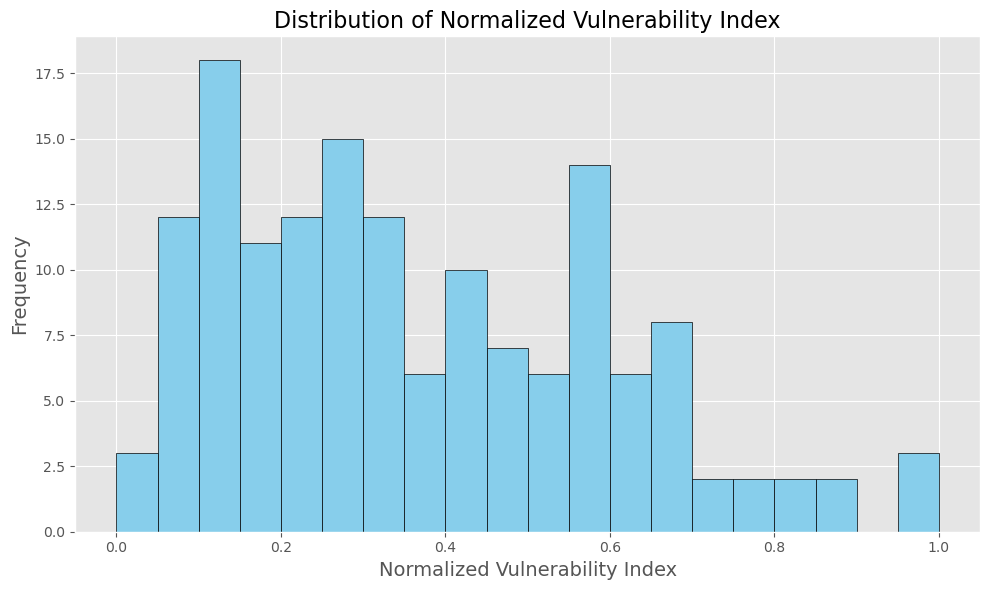

In [58]:
# Let's plot distribution of vulnerability index
plt.figure(figsize=(10, 6))

# Plot histogram with 20 bins
plt.hist(vul_index_df['normalized_V_CT'], bins=20, color='skyblue', edgecolor='black')

# Add title and labels
plt.title('Distribution of Normalized Vulnerability Index', fontsize=16)
plt.xlabel('Normalized Vulnerability Index', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [106]:
vul_index_df

65 years and over (18)  \
Neighbourhood_name                                           
West Humber-Clairville                                5360   
Mount Olive-Silverstone-Jamestown                     4170   
Thistletown-Beaumond Heights                          1740   
Rexdale-Kipling                                       1850   
Elms-Old Rexdale                                      1390   
...                                                    ...   
Yonge-Bay Corridor                                     855   
Junction-Wallace Emerson                              2905   
Dovercourt Village                                    1975   
North Toronto                                         1790   
South Eglinton-Davisville                             3055   

                                    0 to 14 years (3)  \
Neighbourhood_name                                      
West Humber-Clairville                           4295   
Mount Olive-Silverstone-Jamestown                5690   
Thistletown-Beaumond Heights                     1495   
Rexdale-Kipling                                  1575   
Elms-Old Rexdale                                 1610   
...                                               ...   
Yonge-Bay Corridor                                970   
Junction-Wallace Emerson                         3075   
Dovercourt Village                               1365   
North Toronto                                    1315   
South Eglinton-Davisville                        2190   

                                      Parents in one-parent families (38)  \
Neighbourhood_name                                                          
West Humber-Clairville                                               2080   
Mount Olive-Silverstone-Jamestown                                    2450   
Thistletown-Beaumond Heights                                          660   
Rexdale-Kipling                                                       765   
Elms-Old Rexdale                                                      915   
...                                                                   ...   
Yonge-Bay Corridor                                                    390   
Junction-Wallace Emerson                                             1145   
Dovercourt Village                                                    590   
North Toronto                                                         705   
South Eglinton-Davisville                                             855   

                                      Children (39)   Renter (300)  \
Neighbourhood_name                                                   
West Humber-Clairville                        11095           3705   
Mount Olive-Silverstone-Jamestown             12670           5260   
Thistletown-Beaumond Heights                   3475           1220   
Rexdale-Kipling                                3500           1955   
Elms-Old Rexdale                               3685           1430   
...                                             ...            ...   
Yonge-Bay Corridor                             1680           5055   
Junction-Wallace Emerson                       5880           5080   
Dovercourt Village                             2825           2410   
North Toronto                                  2405           7680   
South Eglinton-Davisville                      3550           9170   

                                    French only (428)  \
Neighbourhood_name                                      
West Humber-Clairville                              0   
Mount Olive-Silverstone-Jamestown                  20   
Thistletown-Beaumond Heights                        0   
Rexdale-Kipling                                     0   
Elms-Old Rexdale                                   25   
...                                               ...   
Yonge-Bay Corridor                                 20   
Junction-Wallace Emerson                           25   
Dove

In [109]:
# Save as CSV
vul_index_df[['normalized_V_CT']].to_csv('normalized_V_CT_df.csv', index=True)


<Figure size 1200x600 with 0 Axes>

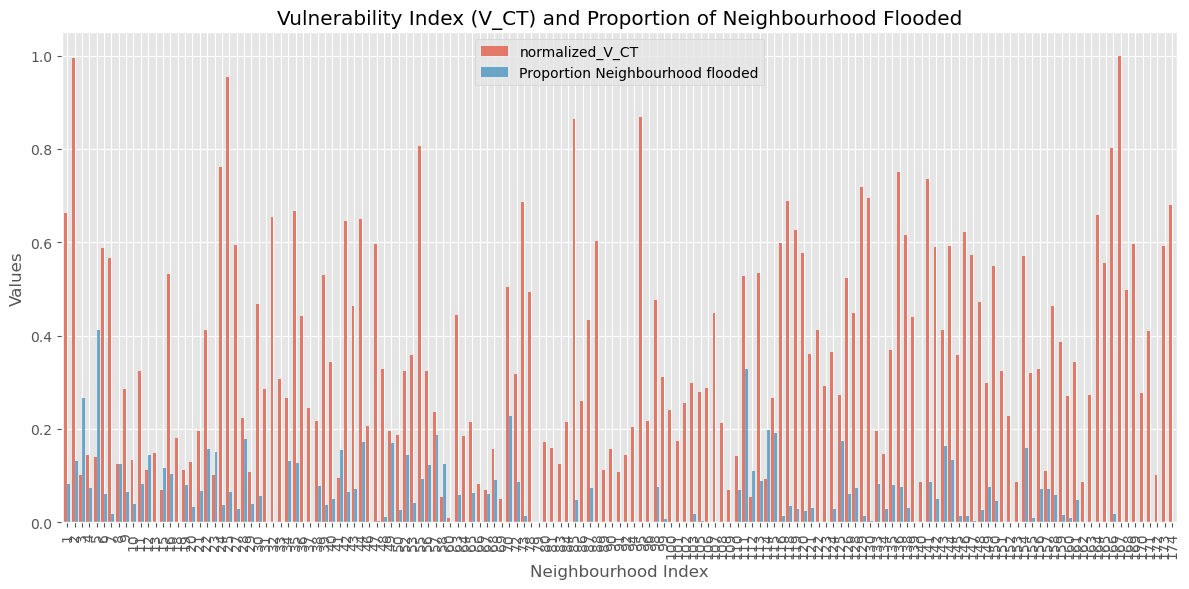

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Check if the required columns exist in the DataFrame
if 'V_CT' in vul_index_df.columns and 'Proportion Neighbourhood flooded' in vul_index_df.columns:
    # Set the figure size
    plt.figure(figsize=(12, 6))
    
    # Plot the bar chart
    vul_index_df[['normalized_V_CT', 'Proportion Neighbourhood flooded']].plot(
        kind='bar',
        figsize=(12, 6),
        width=0.8,
        alpha=0.7,
        title='Vulnerability Index (V_CT) and Proportion of Neighbourhood Flooded',
        legend=True
    )
    
    # Customize the x-axis
    plt.xticks(
        ticks=range(len(vul_index_df)),
        labels=vul_index_df['Neighbourhood Number (0)'],
        rotation=90
    )
    
    # Label the axes
    plt.xlabel('Neighbourhood Index')
    plt.ylabel('Values')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()
else:
    print("One or both columns ('V_CT' or 'Proportion Neighbourhood flooded') are missing from the DataFrame.")


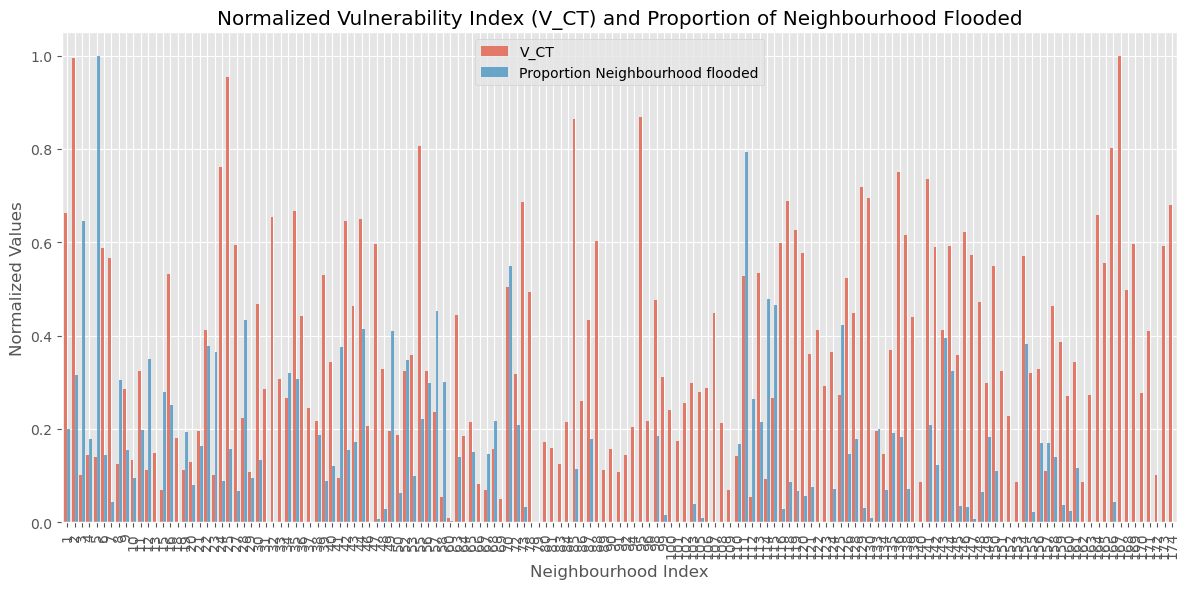

In [44]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Check if the required columns exist in the DataFrame
if 'V_CT' in vul_index_df.columns and 'Proportion Neighbourhood flooded' in vul_index_df.columns:
    # Select the columns to normalize
    columns_to_normalize = ['V_CT', 'Proportion Neighbourhood flooded']
    
    # Normalize the data using Min-Max Scaling
    scaler = MinMaxScaler()
    vul_index_df[columns_to_normalize] = scaler.fit_transform(vul_index_df[columns_to_normalize])
    
    # Plot the normalized bar chart
    vul_index_df[columns_to_normalize].plot(
        kind='bar',
        figsize=(12, 6),
        width=0.8,
        alpha=0.7,
        title='Normalized Vulnerability Index (V_CT) and Proportion of Neighbourhood Flooded',
        legend=True
    )
    
    # Customize the x-axis
    plt.xticks(
        ticks=range(len(vul_index_df)),
        labels=vul_index_df['Neighbourhood Number (0)'],
        rotation=90
    )
    
    # Label the axes
    plt.xlabel('Neighbourhood Index')
    plt.ylabel('Normalized Values')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()
else:
    print("One or both columns ('V_CT' or 'Proportion Neighbourhood flooded') are missing from the DataFrame.")


Pearson Correlation Coefficient: -0.041
Spearman Correlation Coefficient: 0.060


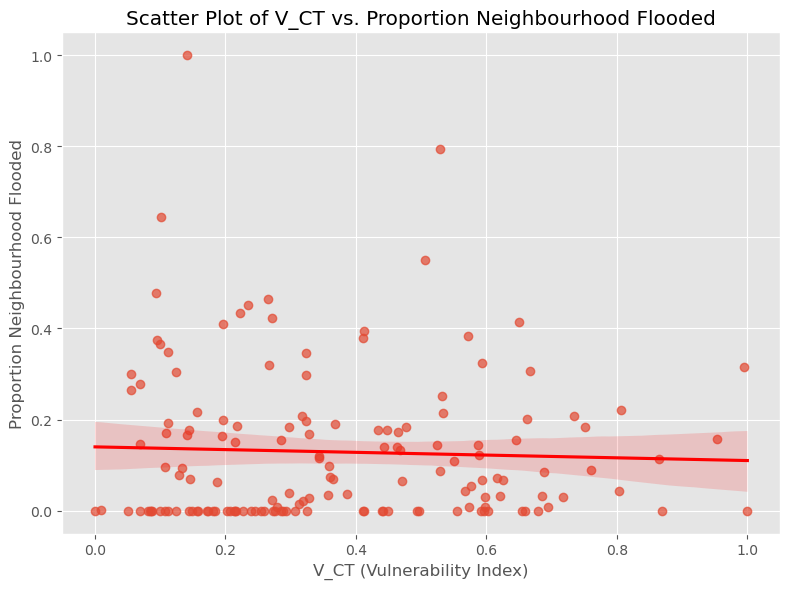

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check if the required columns exist in the DataFrame
if 'V_CT' in vul_index_df.columns and 'Proportion Neighbourhood flooded' in vul_index_df.columns:
    # Calculate Pearson correlation coefficient
    pearson_corr = vul_index_df['V_CT'].corr(vul_index_df['Proportion Neighbourhood flooded'], method='pearson')
    spearman_corr = vul_index_df['V_CT'].corr(vul_index_df['Proportion Neighbourhood flooded'], method='spearman')
    
    print(f"Pearson Correlation Coefficient: {pearson_corr:.3f}")
    print(f"Spearman Correlation Coefficient: {spearman_corr:.3f}")
    
    # Scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(
        x='V_CT',
        y='Proportion Neighbourhood flooded',
        data=vul_index_df,
        scatter_kws={'alpha': 0.7},
        line_kws={'color': 'red'},
    )
    plt.title('Scatter Plot of V_CT vs. Proportion Neighbourhood Flooded')
    plt.xlabel('V_CT (Vulnerability Index)')
    plt.ylabel('Proportion Neighbourhood Flooded')
    plt.tight_layout()
    plt.show()
else:
    print("One or both columns ('V_CT' or 'Proportion Neighbourhood flooded') are missing from the DataFrame.")
